# ËÆ≠ÁªÉÈÉ®ÂàÜÈôÑÂõæ

## Á†îÁ©∂Âå∫‰ΩçÂõæ

### Load data (for sampling)

In [14]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
from function.global_varibles import PATHS
from function import *
us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')
us_argscv = gpd.read_file("figure/draw_shp/ASD_2012_5m.shp")
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')
us_argscv_4326 = us_argscv.to_crs('EPSG:4326')

def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    ‰ΩøÁî®ÁæéÂõΩÂ∑ûÁïå shapefile Ââ™Ë£ÅÁÇπÊï∞ÊçÆÔºõÂÖºÂÆπ‰∏çÂêåÁâàÊú¨ÁöÑ geopandas ÂèÇÊï∞Âêç
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # ÊóßÁâàÊú¨ geopandas ‰ΩøÁî® op ÂèÇÊï∞
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # Ê∏ÖÁêÜ shapefile ÈôÑÂä†Â≠óÊÆµ
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped

# ---------------------------
# 0) Âü∫Á°ÄÂú∞ÁêÜËåÉÂõ¥‰∏éÂ∫ïÂõæ
# ---------------------------
usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
# ---------------------------
# 1) ËØªÂèñÊï∞ÊçÆ
# ---------------------------
df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])

# ÂàùÊ≠•ÁªèÁ∫¨Â∫¶ËåÉÂõ¥ËøáÊª§
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

# Á¨¨‰∫åÊ¨°Áî®Â∑ûÁïåÁü¢ÈáèÊõ¥Á≤æÁ°ÆË£ÅÂâ™
df_abandon = clip_data_with_us_states(df_abandon, us_states)
df_embedding = clip_data_with_us_states(df_embedding, us_states)

# ---------------------------
# 2) Áº∫Â§±ÂÄºÂ°´ÂÖÖ + ÂéªÈáç
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)
df_abandon_filtered=df_abandon_filtered.merge(df_net_benefit[['lon', 'lat', 'area_m2']], on=['lat', 'lon'], how='left')


You want to predict the year: 2020.0
Âàó GDPpc Ê≤°ÊúâÈúÄË¶ÅÂ°´ÂÖÖÁöÑÈùûÊ≠£ÂÄºÊàñNaNÂÄº
Âàó GURdist Ê≤°ÊúâÈúÄË¶ÅÂ°´ÂÖÖÁöÑÈùûÊ≠£ÂÄºÊàñNaNÂÄº
Âàó GDPpc Ê≤°ÊúâÈúÄË¶ÅÂ°´ÂÖÖÁöÑÈùûÊ≠£ÂÄºÊàñNaNÂÄº
Âàó GURdist Ê≤°ÊúâÈúÄË¶ÅÂ°´ÂÖÖÁöÑÈùûÊ≠£ÂÄºÊàñNaNÂÄº


### Helper function for plot

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box, LineString
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.ops import unary_union
try:
    from shapely import make_valid
except Exception:
    make_valid = None
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

def _setup_axes_and_graticule(ax, usa_bounds_main, proj_fwd, proj_inv):
    """ËÆæÁΩÆÂùêÊ†áËΩ¥ÂíåÁªèÁ∫¨Â∫¶ÁΩëÊ†º"""
    # ËÆæÁΩÆÊï∞ÊçÆÊ°ÜÁ∫ø
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_color('black')

    # ÁªèÁ∫¨Â∫¶ÂàªÂ∫¶
    lon_ticks = np.arange(-125, -55, 10)
    lat_ticks = [25, 30, 35, 40, 45, 50]
    
    # ÁªòÂà∂ÁΩëÊ†ºÁ∫øÂíåËÆæÁΩÆÂàªÂ∫¶
    _draw_graticule(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)


def _draw_graticule(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """ÁªòÂà∂ÁªèÁ∫¨Â∫¶ÁΩëÊ†º"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # ËΩ¥Ê°Ü‰∏éÂõõËæπ
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # Ëé∑ÂèñÁªèÁ∫¨Â∫¶ËåÉÂõ¥
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # ÁªèÂ∫¶ÂàªÂ∫¶ÂíåÁΩëÊ†ºÁ∫ø
    xticks, xlabels = [], []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        p = _choose_point_on_edge(line.intersection(bottom))
        if p is None:
            p = _choose_point_on_edge(line.intersection(top))
        if p is not None:
            # Ê£ÄÊü•‰∏éÂ∑≤ÊúâÊ†áÁ≠æÁöÑÊúÄÂ∞èË∑ùÁ¶ª
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])  # 2%ÁöÑÂõæÂÆΩ
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                xlabels.append(f"{abs(int(round(lon)))}¬∞W")

        if i <= len(lon_ticks) :
            ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

    # Á∫¨Â∫¶ÁΩëÊ†ºÁ∫øÔºàÂàªÂ∫¶‰∏çÊòæÁ§∫Ôºâ
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

    # ÂàªÂ∫¶‰∏çÊòæÁ§∫
    ax.xaxis.set_major_locator(mticker.NullLocator())
    ax.xaxis.set_major_formatter(mticker.NullFormatter())
    ax.yaxis.set_major_locator(mticker.NullLocator())
    ax.yaxis.set_major_formatter(mticker.NullFormatter())
    ax.tick_params(axis='both', labelsize=5, pad=1, length=0)



def _draw_glow_outline_outside(ax, gdf_albers, line_color="#444444", line_width=0.8,
                              widths_km=(0, 30, 50), alphas=(0.95, 0.5, 0.3), 
                              colors=("#08336e", "#105ca4", "#3888c0")):
    """ÁªòÂà∂ÂõΩÁïåÁ∫øÂÖâÊôïÊïàÊûú"""
    g = gdf_albers.copy()
    geom = unary_union(g.geometry)
    
    if make_valid is not None:
        geom = make_valid(geom)
    else:
        geom = geom.buffer(0)

    radii_m = [k*1000.0 for k in widths_km]
    ordered = list(zip(radii_m, alphas, colors))
    ordered.sort(key=lambda x: x[0])

    last_inner = geom.buffer(0, join_style=2, cap_style=2)
    glow_meshes = []
    
    for i, (r, alpha, color) in enumerate(ordered):
        outer = geom.buffer(r, join_style=2, cap_style=2)
        ring = outer.difference(last_inner)
        if not ring.is_empty:
            glow_series = gpd.GeoSeries([ring], crs=g.crs)
            glow_mesh = glow_series.plot(ax=ax, color=color, alpha=alpha, edgecolor="none",
                                       zorder=8.2 + i*0.01)
            glow_meshes.append(glow_mesh)
        last_inner = outer

    g.boundary.plot(ax=ax, color=line_color, linewidth=line_width, zorder=9.6)
    return glow_meshes



def _draw_background_map(ax, usa_bounds_main):
    """ÁªòÂà∂ËÉåÊôØÂú∞Âõæ"""
    try:
        bbox_expanded = box(
            usa_bounds_main['lon_min'] - 3, usa_bounds_main['lat_min'] - 3,
            usa_bounds_main['lon_max'] + 3, usa_bounds_main['lat_max'] + 3
        )
        helper_gdf = gpd.read_file(r'figure\draw_shp\ne_110m_land.shp').to_crs(4326)
        helper_gdf = helper_gdf.clip(bbox_expanded)
        
        if 'featurecla' in helper_gdf.columns:
            helper_gdf = helper_gdf[helper_gdf['featurecla'].str.contains('Land', na=False)]
        
        if make_valid is not None:
            helper_gdf['geometry'] = helper_gdf.geometry.map(make_valid)
        else:
            helper_gdf['geometry'] = helper_gdf.geometry.buffer(0)
            
        helper_gdf = helper_gdf[helper_gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])]
        helper_gdf = helper_gdf.explode(index_parts=False, ignore_index=True)
        helper_gdf_proj = helper_gdf.to_crs('ESRI:102003')
        helper_gdf_proj['geometry'] = helper_gdf_proj.buffer(0)
        helper_gdf_proj.plot(ax=ax, facecolor='white', edgecolor='lightgray',
                           linewidth=0.3, alpha=1, zorder=0.5)
    except Exception as e:
        print(f"Helper map error: {e}")

### ÁªòÂõæÂáΩÊï∞

ÂºÉÂÖâÈù¢ÁßØÁªüËÆ°: ÊúÄÂ∞èÂÄº=0.00 ha, ÊúÄÂ§ßÂÄº=515459.22 ha
ÂàÜ‰ΩçÊï∞ËæπÁïå: [  4842.57554868  31649.44167715  64815.69337036 100516.81501499
 184895.73195452]
ÂºÄÂßãËÅöÂêàembeddingÁÇπÔºåÊÄªÊï∞: 10152
Âú∞ÁêÜÂå∫ÂàíËÅöÂêàÁªìÊûú: 312‰∏™Âå∫Âàí
ÂåÖÂê´embeddingÁÇπÁöÑÂå∫ÂàíÊï∞: 236
EmbeddingÁÇπÊï∞ÈáèÂàÜÂ∏É: ÊúÄÂ∞è0.0, ÊúÄÂ§ß1113.0
Ê∞îÊ≥°ÂàÜÁ±ªÁªüËÆ°:
  >1000ÁÇπ: 3‰∏™Âå∫Âàí (Ê∑±ÁªøËâ≤, 80)
  800-1000ÁÇπ: 0‰∏™Âå∫Âàí (ÁªøËâ≤, 60)
  100-800ÁÇπ: 18‰∏™Âå∫Âàí (ÊµÖÁªøËâ≤, 40)
  50-100ÁÇπ: 13‰∏™Âå∫Âàí (ÊµÖËìùËâ≤, 25)
  10-50ÁÇπ: 63‰∏™Âå∫Âàí (ËìùËâ≤, 15)
  <10ÁÇπ: 215‰∏™Âå∫ÂàíÔºà‰∏çÁªòÂà∂Ôºâ
EmbeddingÁÇπËÅöÂêàÂÆåÊàê: ÂéüÂßã10152‰∏™ÁÇπ ‚Üí 312‰∏™Âú∞ÁêÜÂå∫Âàí


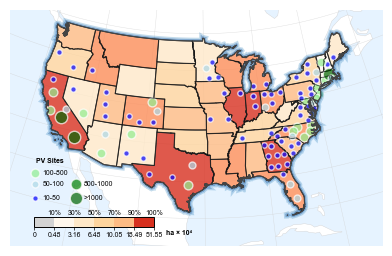

In [20]:
def plot_smaplesites_nature_style(
    df_abandon_filtered, 
    us_counties_4326, 
    df_pv_embedding,
    add_north_arrow_and_scalebar=True,
    add_embedding_points=False  
):
    """
    ÂèÇÊï∞:
        df_abandon_filtered: DataFrameÔºåÂåÖÂê´Ë¶ÅÁªòÂà∂ÁöÑÊíÇËçíÁÇπÔºåÂøÖÈ°ªÂåÖÂê´'lat'„ÄÅ'lon'Âíå'area_m2'Âàó
        us_counties_4326: GeoDataFrameÔºåÁæéÂõΩÂêÑÂéøËæπÁïå
        df_pv_embedding: DataFrameÔºåÂåÖÂê´Ë¶ÅÁªòÂà∂ÁöÑembeddingÊï∞ÊçÆÔºåÂøÖÈ°ªÂåÖÂê´'lat'Âíå'lon'Âàó
        add_north_arrow_and_scalebar: bool, ÊòØÂê¶Ê∑ªÂä†ÊåáÂåóÈíàÂíåÊØî‰æãÂ∞∫
        add_embedding_points: bool, ÊòØÂê¶ÁªòÂà∂embeddingÁÇπ

        ÊåâÁÖßcountyËÅöÂêàdf_abandon_filteredÁöÑÈù¢ÁßØÔºåÁÑ∂Âêé‰ª•ÂàÜ‰ΩçÊï∞ÂàíÂàÜÁªòÂà∂
        ‰ª•Ê∞îÊ≥°ËÅöÂêàÁöÑÂΩ¢ÂºèÁªòÂà∂df_pv_embeddingÁöÑÁÇπ
    """
    
    # ==================== 1. ÂàùÂßãËÆæÁΩÆ ====================
    plt.rcParams.update({
        "font.family": "Arial",
        "pdf.fonttype": 42, 
        "ps.fonttype": 42,
        "axes.linewidth": 0.5, 
        "axes.edgecolor": "black",
        "ps.usedistiller": "ghostscript",
        "ps.distiller.res": 6000,
    })

    # ÂàõÂª∫ÂõæÂΩ¢ÂíåÂùêÊ†áËΩ¥
    fig, ax = plt.subplots(1, 1, figsize=(100/25.4, 60/25.4))
    ax.set_autoscale_on(False)
    fig.patch.set_facecolor('white')      
    ax.set_facecolor('#e6f3ff')

    # ==================== 2. Âú∞ÁêÜËæπÁïåËÆæÁΩÆ ====================
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    
    # Â§ÑÁêÜÂéøÁïåÊï∞ÊçÆ
    us_counties_bound = us_counties_4326.to_crs(epsg=4326).clip(bbox)
    us_counties_albers = us_counties_bound.to_crs('ESRI:102003')
    
    # Â§ÑÁêÜÂõΩÁïåÁ∫ø
    us_nation_bound = us_nation.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')

    # ==================== 3. ÂùêÊ†áÂèòÊç¢ËÆæÁΩÆ ====================
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    # ==================== 4. Âú∞ÂõæËåÉÂõ¥ËÆ°ÁÆó ====================
    xmin, ymin, xmax, ymax = us_counties_albers.total_bounds

    # ËæπÁïåË∞ÉÊï¥
    margin_x_left = (xmax - xmin) * 0.08   # Â¢ûÂ§ßÂ∑¶ËæπÁïå
    margin_x_right = (xmax - xmin) * 0.02  # ÂáèÂ∞èÂè≥ËæπÁïå
    margin_y = (ymax - ymin) * 0.08

    # Âú®yminÁïôÊõ¥Â§öÁ©∫Áªôcolor bar
    colorbar_space = (ymax - ymin) * 0.08  
    xmin = xmin - margin_x_left
    xmax = xmax + margin_x_right
    ymin = ymin - margin_y * 1 - colorbar_space
    ymax = ymax + margin_y * 0.8

    # ÁîªÂ∏ÉÊØî‰æãË∞ÉÊï¥
    fig_width, fig_height = fig.get_size_inches()
    aspect_ratio = fig_width / fig_height
    data_width = xmax - xmin
    data_height = ymax - ymin
    data_aspect = data_width / data_height
    
    if data_aspect > aspect_ratio:
        # Êï∞ÊçÆËøáÂÆΩÔºåË∞ÉÊï¥yËåÉÂõ¥Ôºå‰øùÊåÅ‰∏≠ÂøÉ
        center_y = (ymin + ymax) / 2
        new_height = data_width / aspect_ratio
        ymin = center_y - new_height / 2
        ymax = center_y + new_height / 2
        # ÈÄÇÂ∫¶ÊîæÂ§ßyËåÉÂõ¥ÔºåÈÅøÂÖçËæπÁïåË£ÅÂàá
        ymin *= 1.05
        ymax *= 1.05
    else:
        # Êï∞ÊçÆÂÅèÈ´òÔºåË∞ÉÊï¥xËåÉÂõ¥Ôºå‰øùÊåÅ‰∏≠ÂøÉ
        center_x = (xmin + xmax) / 2
        new_width = data_height * aspect_ratio
        xmin = center_x - new_width / 2
        xmax = center_x + new_width / 2
        # ÈÄÇÂ∫¶Êî∂Áº©xËåÉÂõ¥ÔºåÁ™ÅÂá∫‰∏ª‰Ωì
        xmin *= 0.9
        xmax *= 1

    # ËÆæÁΩÆÂùêÊ†áËΩ¥‰ΩçÁΩÆÂíåËåÉÂõ¥
    ax.set_position([0.0, 0.08, 1, 0.87])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ==================== 5. Âú∞ÂõæÂÖÉÁ¥†ÁªòÂà∂ ====================
    # ÁªòÂà∂ÂõΩÁïåÁ∫øÂÖâÊôïÊïàÊûú
    _draw_glow_outline_outside(ax, us_nation_albers)
    
    # ÁªòÂà∂ÂéøÁïå
    us_counties_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4, alpha=0.4, zorder=9)

    # ==================== 6. ÂùêÊ†áËΩ¥ËÆæÁΩÆ ====================
    _setup_axes_and_graticule(ax, usa_bounds_main, proj_fwd, proj_inv)

    # ==================== 7. ËÉåÊôØÂú∞Âõæ ====================
    _draw_background_map(ax, usa_bounds_main)

    # ==================== 8. Êï∞ÊçÆÂèØËßÜÂåñ ====================
    # ÁªòÂà∂df_abandon_filteredÁöÑÈù¢ÁßØÂú®county‰∏äÁöÑËÅöÂêà
    # 1. ÂÖàÂ∞ÜÂºÉÂÖâÁÇπËΩ¨‰∏∫GeoDataFrame
    gdf_abandon = gpd.GeoDataFrame(
        df_abandon_filtered,
        geometry=gpd.points_from_xy(df_abandon_filtered['lon'], df_abandon_filtered['lat']),
        crs='EPSG:4326'
    )
    # 2. ÊäïÂΩ±Âà∞Albers
    gdf_abandon = gdf_abandon.to_crs('ESRI:102003')
    # 3. Á©∫Èó¥ËøûÊé•Âà∞countyÔºåÁªüËÆ°ÊØè‰∏™countyÁöÑÂºÉÂÖâÈù¢ÁßØÊÄªÂíå
    county_abandon_area = gpd.sjoin(
        gdf_abandon, us_counties_albers, how='left', predicate='within'
    ).groupby('index_right')['area_m2'].sum()
    # 4. ÂêàÂπ∂Âõûcounty GeoDataFrame
    us_counties_albers['abandon_area_ha'] = county_abandon_area / 10000  # ËΩ¨Êç¢‰∏∫ÂÖ¨È°∑
    us_counties_albers['abandon_area_ha'] = us_counties_albers['abandon_area_ha'].fillna(0)

    # 5. ÁªòÂà∂Â∫ïÂõæÔºàcountyËæπÁïåÔºåÂºÉÂÖâÈù¢ÁßØÁî®ÂàÜ‰ΩçÊï∞ÂàíÂàÜÔºâ
    # ËÆ°ÁÆóÂàÜ‰ΩçÊï∞ËæπÁïå
    area_values = us_counties_albers['abandon_area_ha'].values
    area_quantiles = np.percentile(area_values[area_values > 0], [10, 30, 50, 70, 90])  # ÊéíÈô§0ÂÄºËÆ°ÁÆóÂàÜ‰ΩçÊï∞
    
    # ÂàõÂª∫ÂàÜ‰ΩçÊï∞ÂàÜÁ±ª
    def classify_area(area):
        if area == 0:
            return 0  # Êó†ÂºÉÂÖâ
        elif area <= area_quantiles[0]:
            return 1  # 0-10%ÂàÜ‰ΩçÊï∞
        elif area <= area_quantiles[1]:
            return 2  # 20-40%ÂàÜ‰ΩçÊï∞
        elif area <= area_quantiles[2]:
            return 3  # 40-60%ÂàÜ‰ΩçÊï∞
        elif area <= area_quantiles[3]:
            return 4  # 60-80%ÂàÜ‰ΩçÊï∞
        elif area <= area_quantiles[4]:
            return 5  # 80-95%ÂàÜ‰ΩçÊï∞
        else:
            return 6  # 95-100%ÂàÜ‰ΩçÊï∞
    
    us_counties_albers['area_class'] = us_counties_albers['abandon_area_ha'].apply(classify_area)
    
    print(f"ÂºÉÂÖâÈù¢ÁßØÁªüËÆ°: ÊúÄÂ∞èÂÄº={area_values.min():.2f} ha, ÊúÄÂ§ßÂÄº={area_values.max():.2f} ha")
    print(f"ÂàÜ‰ΩçÊï∞ËæπÁïå: {area_quantiles}")
    
    # ÂàõÂª∫Ëá™ÂÆö‰πâÈ¢úËâ≤Êò†Â∞ÑÔºöÁÅ∞Ëâ≤Âà∞YlOrRd
    colors = ['#D3D3D3', '#fff7ec', '#fee8c8', '#fdd49e', '#fdbb84', '#fc8d59', '#d7301f']
    custom_cmap = ListedColormap(colors)
    
    # ÁªòÂà∂countyËÅöÂêàÁöÑÂºÉÂÖâÈù¢ÁßØ
    plot_result = us_counties_albers.plot(
        ax=ax,
        column='area_class',
        cmap=custom_cmap,
        linewidth=0.8,
        edgecolor='#333333',
        alpha=0.8,
        zorder=2,
        legend=False
    )

    # 6. ÁªòÂà∂embeddingÁÇπÔºàÊ∞îÊ≥°ËÅöÂêàÔºâ
    legend_bubbles = []
    if add_embedding_points and (df_pv_embedding is not None):
        print(f"ÂºÄÂßãËÅöÂêàembeddingÁÇπÔºåÊÄªÊï∞: {len(df_pv_embedding)}")
        
        # ‰ΩøÁî®us_argscv_4326ÁöÑÂú∞ÁêÜÂå∫ÂàíËøõË°åËÅöÂêà
        # 1. ÂÖàÂ∞ÜembeddingÁÇπËΩ¨‰∏∫GeoDataFrame
        gdf_embedding = gpd.GeoDataFrame(
            df_pv_embedding,
            geometry=gpd.points_from_xy(df_pv_embedding['lon'], df_pv_embedding['lat']),
            crs='EPSG:4326'
        )
        
        # 2. ÊäïÂΩ±Âà∞Albers
        gdf_embedding = gdf_embedding.to_crs('ESRI:102003')
        
        # 3. Á©∫Èó¥ËøûÊé•Âà∞Âú∞ÁêÜÂå∫ÂàíÔºåÁªüËÆ°ÊØè‰∏™Âå∫ÂàíÂÜÖÁöÑÁÇπÊï∞
        us_argscv_albers = us_argscv_4326.to_crs('ESRI:102003')
        district_embedding_count = gpd.sjoin(
            gdf_embedding, us_argscv_albers, how='left', predicate='within'
        ).groupby('index_right').size()
        us_argscv_albers['embedding_count'] = district_embedding_count
        us_argscv_albers['embedding_count'] = us_argscv_albers['embedding_count'].fillna(0)
        
        print(f"Âú∞ÁêÜÂå∫ÂàíËÅöÂêàÁªìÊûú: {len(us_argscv_albers)}‰∏™Âå∫Âàí")
        print(f"ÂåÖÂê´embeddingÁÇπÁöÑÂå∫ÂàíÊï∞: {(us_argscv_albers['embedding_count'] > 0).sum()}")
        print(f"EmbeddingÁÇπÊï∞ÈáèÂàÜÂ∏É: ÊúÄÂ∞è{us_argscv_albers['embedding_count'].min()}, ÊúÄÂ§ß{us_argscv_albers['embedding_count'].max()}")
        
        # 5. Ê†πÊçÆÂå∫ÂàíÂÜÖÁÇπÊï∞ÂàÜÁ±ªÂπ∂ËÆæÁΩÆÊ∞îÊ≥°Â§ßÂ∞èÂíåÈ¢úËâ≤ÔºàË∞ÉÊï¥‰∏∫Êõ¥ÂêàÁêÜÁöÑÂ§ßÂ∞èÔºâ
        def classify_district_size(count):
            if count > 1000:
                return 80, 'darkgreen', '>1000'      # ‰ªé500Ë∞ÉÊï¥‰∏∫80
            elif count > 800:
                return 60, 'green', '800-1000'       # ‰ªé350Ë∞ÉÊï¥‰∏∫60
            elif count > 100:
                return 40, 'lightgreen', '100-800'   # ‰ªé200Ë∞ÉÊï¥‰∏∫40
            elif count > 50:
                return 25, 'lightblue', '50-100'     # ‰ªé120Ë∞ÉÊï¥‰∏∫25
            elif count > 10:
                return 15, 'blue', '10-50'           # ‰ªé60Ë∞ÉÊï¥‰∏∫15
            else:
                return 0, 'none', None
        
        # 6. ÁªòÂà∂Ê∞îÊ≥°
        for idx, row in us_argscv_albers.iterrows():
            count = row['embedding_count']
            if count > 10:
                center = row.geometry.centroid
                center_x, center_y = center.x, center.y
                bubble_size, bubble_color, bubble_label = classify_district_size(count)
                if bubble_label and bubble_label not in [b[2] for b in legend_bubbles]:
                    legend_bubbles.append((bubble_size, bubble_color, bubble_label))
                    ax.scatter(
                        center_x, center_y,
                        s=bubble_size,
                        c=bubble_color,
                        marker='o',
                        alpha=0.7,
                        edgecolors='white',
                        linewidth=1.0,
                        zorder=6,
                        label=bubble_label
                    )
                else:
                    ax.scatter(
                        center_x, center_y,
                        s=bubble_size,
                        c=bubble_color,
                        marker='o',
                        alpha=0.7,
                        edgecolors='white',
                        linewidth=1.0,
                        zorder=6
                    )
        
        # ÁªüËÆ°ÂêÑÁ±ªÊ∞îÊ≥°ÁöÑÊï∞Èáè
        district_sizes = us_argscv_albers['embedding_count'].values
        large_districts = np.sum(district_sizes > 1000)
        medium_large_districts = np.sum((district_sizes > 800) & (district_sizes <= 1000))
        medium_districts = np.sum((district_sizes > 100) & (district_sizes <= 800))
        medium_small_districts = np.sum((district_sizes > 50) & (district_sizes <= 100))
        small_districts = np.sum((district_sizes > 10) & (district_sizes <= 50))
        
        print(f"Ê∞îÊ≥°ÂàÜÁ±ªÁªüËÆ°:")
        print(f"  >1000ÁÇπ: {large_districts}‰∏™Âå∫Âàí (Ê∑±ÁªøËâ≤, 80)")
        print(f"  800-1000ÁÇπ: {medium_large_districts}‰∏™Âå∫Âàí (ÁªøËâ≤, 60)")
        print(f"  100-800ÁÇπ: {medium_districts}‰∏™Âå∫Âàí (ÊµÖÁªøËâ≤, 40)")
        print(f"  50-100ÁÇπ: {medium_small_districts}‰∏™Âå∫Âàí (ÊµÖËìùËâ≤, 25)")
        print(f"  10-50ÁÇπ: {small_districts}‰∏™Âå∫Âàí (ËìùËâ≤, 15)")
        print(f"  <10ÁÇπ: {np.sum(district_sizes <= 10)}‰∏™Âå∫ÂàíÔºà‰∏çÁªòÂà∂Ôºâ")
        
        print(f"EmbeddingÁÇπËÅöÂêàÂÆåÊàê: ÂéüÂßã{len(df_pv_embedding)}‰∏™ÁÇπ ‚Üí {len(us_argscv_albers)}‰∏™Âú∞ÁêÜÂå∫Âàí")

    # ==================== 9. È¢úËâ≤Êù° ====================
    _add_colorbar_sites(fig, ax, custom_cmap, area_values, area_quantiles)

    # ==================== 10. Ê∞îÊ≥°Âõæ‰æã ====================
    if add_embedding_points and (df_pv_embedding is not None):
        _add_bubble_legend(fig, ax)

    fig.canvas.draw()
    
    ax.set_position([0.0, 0.0, 1, 1]) 

    return fig, ax


def _add_colorbar_sites(fig, ax, custom_cmap, area_values, area_quantiles):
    """Ê∑ªÂä†È¢úËâ≤Êù° - ÂèÇÁÖßplot_single_variable_nature_styleÁöÑÈ£éÊ†º"""
    def add_horizontal_cbar_sites(fig, ax, mappable, var_bins, unit_display=None):
        pos = ax.get_position()
        left = pos.x0 + 0 * pos.width
        bottom = pos.y0 + 0 * pos.height
        width = 0.37 * pos.width
        height = 0.05 * pos.height

        cax = fig.add_axes([left, bottom, width, height])
        cax.set_in_layout(False)
        cax.set_zorder(5)  # Ëøõ‰∏ÄÊ≠•Èôç‰Ωézorder
        cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')

        cb.set_ticks([0, 1, 2, 3, 4, 5, 6])

        # Ê†ºÂºèÂåñÂàªÂ∫¶Ê†áÁ≠æ 
        area_labels = []
        area_labels.append('0')
        area_labels.append(f'{area_quantiles[0]/10000:.2f}')
        area_labels.append(f'{area_quantiles[1]/10000:.2f}')
        area_labels.append(f'{area_quantiles[2]/10000:.2f}')
        area_labels.append(f'{area_quantiles[3]/10000:.2f}')
        area_labels.append(f'{area_quantiles[4]/10000:.2f}')
        area_labels.append(f'{area_values.max()/10000:.2f}')
        cb.set_ticklabels(area_labels)

        # ÁªÜÈïø
        cax.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=1, labelsize=5)
        cax.tick_params(axis='x', which='minor', length=1.5, width=0.4, label1On=False)
        cb.outline.set_linewidth(0.7)

        # ÁôæÂàÜ‰ΩçÊ†áÁ≠æÔºàÂéªÊéâÊúÄÂ§ñÂ±ÇÁöÑ0%Âíå100%Ôºâ
        percentile_labels = ['10%', '30%', '50%', '70%', '90%', '100%']  # Âè™‰øùÁïô‰∏≠Èó¥ÁöÑÂàÜ‰ΩçÊï∞
        major_tick_locs = cb.get_ticks()[1:]  # Âè™ÂéªÊéâÈ¶ñÔºå‰∏çÂéªÊéâÂ∞æ
        for loc, label in zip(major_tick_locs, percentile_labels):
            x_disp = cax.transData.transform((loc, 0))[0]
            x_frac = cax.transAxes.inverted().transform((x_disp, 0))[0]
            cax.text(x_frac, 1.1, label, transform=cax.transAxes,
                    ha='center', va='bottom', fontsize=5, clip_on=False)

        # ÁßªÈô§clip_pathËÆæÁΩÆÔºåÈÅøÂÖçÊà™Êñ≠ÂÖ∂‰ªñÂÖÉÁ¥†
        # for ch in cax.get_children():
        #     try:
        #         ch.set_clip_path(cax.patch)
        #     except Exception:
        #         pass

        return cax, cb

    # ÂàõÂª∫ScalarMappableÁî®‰∫écolorbar
    from matplotlib.cm import ScalarMappable
    norm = mcolors.BoundaryNorm([0, 1, 2, 3, 4, 5, 6], custom_cmap.N)
    sm = ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])

    cbar_ax, cbar = add_horizontal_cbar_sites(fig, ax, sm, [0, 1, 2, 3, 4, 5, 6], "ha")
    cbar_ax.text(1.1, -0.3, "ha √ó 10‚Å¥", ha='left', va='top', fontsize=5, 
                fontweight='bold', transform=cbar_ax.transAxes)


def _add_bubble_legend(fig, ax):
    """Ê∑ªÂä†Ê∞îÊ≥°Âõæ‰æãÔºàË∞ÉÊï¥Ê∞îÊ≥°Â§ßÂ∞è‰∏∫Êõ¥ÂêàÁêÜÁöÑÂ§ßÂ∞èÔºâ"""
    # Âú®colorbar‰∏äÊñπÊ∑ªÂä†embeddingÁÇπÁöÑÂõæ‰æã
    legend_ax = inset_axes(ax, width="20%", height="32%",
                          loc='lower left',
                          bbox_to_anchor=(0.02, 0.16, 1, 1),
                          bbox_transform=ax.transAxes, borderpad=1)
    legend_ax.set_xlim(-0.05, 1.05)
    legend_ax.set_ylim(-0.05, 1.05)
    legend_ax.set_xticks([])
    legend_ax.set_yticks([])
    
    for spine in legend_ax.spines.values():
        spine.set_visible(False)
    legend_ax.set_facecolor('none')
    legend_ax.set_zorder(20)  # ÊèêÈ´òzorderÔºåÁ°Æ‰øùÂú®colorbar‰πã‰∏ä
    
    # Âõæ‰æãÈ°πÂèÇÊï∞ÔºàË∞ÉÊï¥‰∏∫Êõ¥ÂêàÁêÜÁöÑÂ§ßÂ∞èÔºâ
    legend_items = [
        # (size, color, label, x, y)
        (40, 'lightgreen', '100-800', 0.05, 0.28),
        (25, 'lightblue', '50-100', 0.05, 0.14),
        (15, 'blue', '10-50', 0.05, -0.05),
        (60, 'green', '800-1000', 0.6, 0.14),
        (80, 'darkgreen', '>1000', 0.6, -0.05),
    ]
    
    for size, color, label, x, y in legend_items:
        legend_ax.scatter(x, y, s=size, c=color, marker='o', alpha=0.7,
                         edgecolors='white', linewidth=1.0, zorder=25, transform=legend_ax.transAxes,clip_on=False)
        legend_ax.text(x+0.10, y, label, ha='left', va='center', fontsize=5, color='black',
                      fontweight='normal', transform=legend_ax.transAxes, zorder=25)
    
    # Ê∑ªÂä†Âõæ‰æãÊ†áÈ¢ò
    legend_ax.text(0.25, 0.45, "PV Sites", ha='center', va='center', fontsize=5, 
                  fontweight='bold', transform=legend_ax.transAxes, zorder=25)


def _setup_axes_and_graticule(ax, usa_bounds_main, proj_fwd, proj_inv):
    """ËÆæÁΩÆÂùêÊ†áËΩ¥ÂíåÁªèÁ∫¨Â∫¶ÁΩëÊ†ºÔºàÂéªÊéâÂ§ñÊ°ÜÁ∫øÔºâ"""
    # ÂéªÊéâÂ§ñÊ°ÜÁ∫ø
    for spine in ax.spines.values():
        spine.set_visible(False)

    # ÁªèÁ∫¨Â∫¶ÂàªÂ∫¶
    lon_ticks = np.arange(-125, -55, 10)
    lat_ticks = [25, 30, 35, 40, 45, 50]
    
    # ÁªòÂà∂ÁΩëÊ†ºÁ∫øÂíåËÆæÁΩÆÂàªÂ∫¶
    _draw_graticule(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)
import os

fig, ax = plot_smaplesites_nature_style(
    df_abandon_filtered, 
    us_states_4326, 
    df_embedding,
    add_north_arrow_and_scalebar=False,
    add_embedding_points=True
)

output_dir = os.path.join('figure', 'US_figure', 'US_workflow')
os.makedirs(output_dir, exist_ok=True)
fig.savefig(os.path.join(output_dir, 'sample_sites.png'), dpi=300, format='png')
fig.savefig(os.path.join(output_dir, 'sample_sites.pdf'), dpi=300, format='pdf')




## ÁâπÂæÅÊèêÂèñÂõæ

### Extract data from ds

In [2]:
from function import load_all_ds_emission, load_all_ds

ds_carbon=load_all_ds_emission()
ds_feat=load_all_ds()
output_dir = r'D:\xarray\us_aligned'



gogogo


c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 174
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anacon

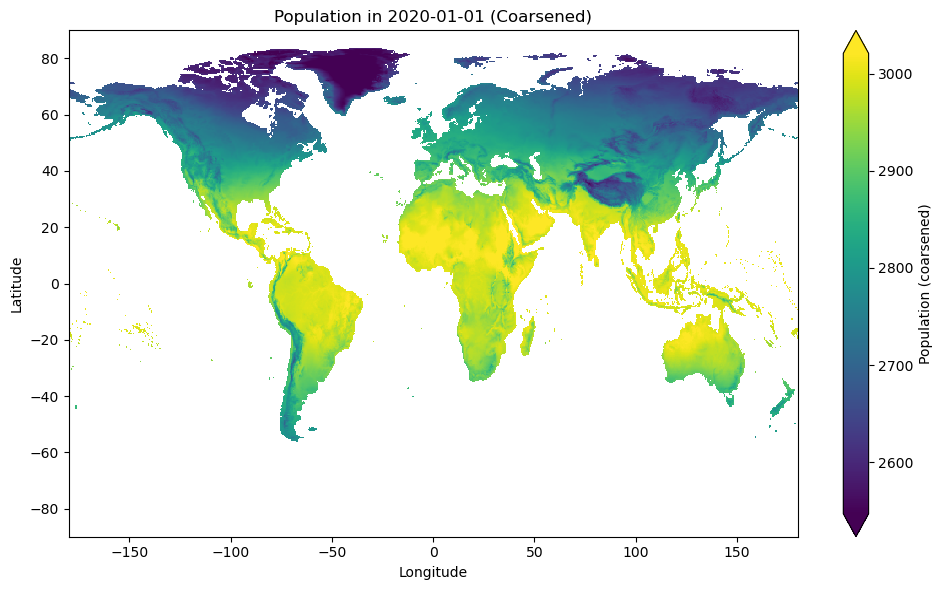

In [3]:
import matplotlib.pyplot as plt

# Select the Population data for 2020-01-01
pop_2020 = ds_feat['tas'].sel(time='2020-01-01')

# Coarsen the data for faster/lower-res plotting (e.g., by factor of 5 in both dims)
pop_2020_coarse = pop_2020.coarsen(lat=50, lon=50, boundary='trim').mean()

# Plot the coarsened data
plt.figure(figsize=(10, 6))
pop_2020_coarse.plot(
    cmap='viridis',
    robust=True,
    cbar_kwargs={'label': 'Population (coarsened)'}
)
plt.title('Population in 2020-01-01 (Coarsened)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

In [4]:
import rasterio
from rasterio.features import geometry_mask
import affine
import geopandas as gpd
from shapely.geometry import mapping,box
import xarray as xr



us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')






### Plot each variable 

In [7]:
# ==== ÂøÖË¶ÅÂ∫ìÂØºÂÖ• ====
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap, LogNorm
import matplotlib.ticker as mticker
from matplotlib.ticker import LogLocator, ScalarFormatter, MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.geometry import box, mapping, LineString
from pyproj import Transformer
import xarray as xr
import geopandas as gpd
import matplotlib.patches as mpatches

# ==== ÂàÜÁ±ªÂõæ‰æãÊ†∑ÂºèÔºö1~9 Á±ª ====
LANDCOVER_LABELS = {
    1: "Cropland",
    2: "Forest",
    3: "Savanna",
    4: "Shrub",
    5: "Grassland and Arid Ecosystem",
    6: "Wetland",
    7: "Built-up",
    8: "Bare Area and Ice",
    9: "Water",
}
# È¢úËâ≤Â∞ΩÈáèËâ≤Áõ≤ÂèãÂ•Ω & Âå∫ÂàÜÂ∫¶È´ò
LANDCOVER_COLORS = {
    1: "#FFD24D",  # Cropland
    2: "#2CA25F",  # Forest
    3: "#A1D76A",  # Savanna
    4: "#8C6D31",  # Shrub
    5: "#F1E2A1",  # Grassland & Arid
    6: "#2CB1B1",  # Wetland (teal)
    7: "#CB181D",  # Built-up (red)
    8: "#BDBDBD",  # Bare/Ice (grey)
    9: "#2171B5",  # Water (blue)
}

def _landcover_cmap_norm():
    # Á±ªÂà´‰ªé 1..9 Êò†Â∞ÑÂà∞ 0..8 ÁöÑËâ≤Ê†áÁ¥¢Âºï
    ordered_cols = [LANDCOVER_COLORS[i] for i in range(1, 10)]
    cmap = ListedColormap(ordered_cols, name="landcover9")
    bounds = np.arange(0.5, 9.5 + 1, 1.0)         # 0.5, 1.5, ..., 9.5
    norm = BoundaryNorm(bounds, ncolors=cmap.N)
    return cmap, norm

def _add_landcover_legend(ax, data_values):
    present = sorted({int(v) for v in np.unique(data_values[np.isfinite(data_values)]) if 1 <= int(v) <= 9})
    handles = [mpatches.Patch(facecolor=LANDCOVER_COLORS[v], edgecolor='none',
                              label=f"{v}. {LANDCOVER_LABELS[v]}") for v in present]
    # Â∑¶‰∏ãËßíÂÜÖÂµåÂõæ‰æã
    leg = ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.01, 0.01),
                    fontsize=6, ncol=3, frameon=True, framealpha=0.9,
                    columnspacing=0.8, handlelength=1.2, borderpad=0.3)
    for txt in leg.get_texts():
        txt.set_color("#333333")

# ËøûÁª≠ÂèòÈáèÔºöÊåâÂèòÈáèÂêçÁªôÈªòËÆ§Ëâ≤Â∏¶ÔºõÂèØË¢´ colors ÂèÇÊï∞Ë¶ÜÁõñ
_CONT_STYLES = {
    "DEM":         dict(cmap="terrain",   log=False,  pct=(2, 98)),
    "gdmp":        dict(cmap="YlGn",      log=False,  pct=(2, 98)),
    "Population":  dict(cmap="Blues",     log=True,   pct=(2, 98)),  # Âä®ÊÄÅËåÉÂõ¥Â§ßÊó∂Ëá™Âä® Log
    "Powerdist":   dict(cmap="OrRd",      log=False,  pct=(2, 98)),
    "rsds":        dict(cmap="YlOrRd",    log=False,  pct=(2, 98)),
    "tas":         dict(cmap="coolwarm",  log=False,  pct=(2, 98)),
}

def _prepare_continuous_cmap_norm(variable_name, data_values, user_colors=None):
    finite = data_values[np.isfinite(data_values)]
    if finite.size == 0:
        vmin, vmax = 0.0, 1.0
    else:
        pct = _CONT_STYLES.get(variable_name, dict(pct=(2, 98)))["pct"]
        vmin, vmax = np.nanpercentile(finite, list(pct))
        if vmin == vmax:  # Â∏∏Êï∞Âú∫ÂÖúÂ∫ï
            vmin, vmax = vmin - 0.5, vmax + 0.5

    style = _CONT_STYLES.get(variable_name, {})
    cmap_name = style.get("cmap", None)
    use_log  = style.get("log", False)

    if user_colors is not None and len(user_colors) >= 2:
        cmap = LinearSegmentedColormap.from_list(f"{variable_name}_cmap", user_colors, N=256)
    elif cmap_name is not None:
        cmap = plt.get_cmap(cmap_name)
    else:
        cmap = LinearSegmentedColormap.from_list("default_oranges",
                     ['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#d7301f'], N=256)

    # Ëã•Âä®ÊÄÅËåÉÂõ¥ÊûÅÂ§ß & ÂÖ®ÈÉ®‰∏∫Ê≠£ÔºåÂàôÂº∫Âà∂ log
    if use_log and vmin > 0 and (vmax / max(vmin, 1e-12) > 200):
        norm = LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    return cmap, norm

def _add_colorbar_continuous_pretty(fig, ax, im, variable_name, unit, norm):
    cax = inset_axes(ax, width="32%", height="3%", loc='lower left',
                     bbox_to_anchor=(0.02, 0.02, 1, 1), bbox_transform=ax.transAxes)
    cb = fig.colorbar(im, cax=cax, orientation='horizontal')
    # ÂàªÂ∫¶ÊéßÂà∂ÔºöLog/Á∫øÊÄßËá™ÈÄÇÂ∫î
    if isinstance(norm, LogNorm):
        cb.locator = LogLocator(numticks=6)
        cb.formatter = ScalarFormatter()
    else:
        cb.ax.locator_params(nbins=6)
    cb.update_ticks()
    # Âçï‰ΩçÊ†áÁ≠æ
    label = unit if unit else ""
    cb.set_label(label, fontsize=6, labelpad=2)
    cb.ax.tick_params(labelsize=6, length=2)

# ================== ‰∏ªÂáΩÊï∞ ==================
def plot_variable_optimized_final_fixed(
    ds_feat_var, variable_name,
    us_states_gdf, us_nation_gdf,
    title=None, unit=None, colors=None,
    coarsening_factor=100, figsize=(100/25.4, 60/25.4)
):
    """‰ºòÂåñÁâàÔºöÂàÜÁ±ªÂèòÈáèÁî® LegendÔºõËøûÁª≠ÂèòÈáèÁî®ÊºÇ‰∫ÆËâ≤Êù°ÔºõÂÖ∂‰ΩôÁªòÂà∂ÈÄªËæë‰∏é‰πãÂâç‰∏ÄËá¥„ÄÇ"""
    # ---------- 1) ÁîªÂ∏É ----------
    plt.rcParams.update({
        "font.family":"Arial","pdf.fonttype":42,"ps.fonttype":42,
        "axes.linewidth":0.5,"axes.edgecolor":"black",
    })
    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.set_autoscale_on(False)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("#e6f3ff")

    # ---------- 2) Ê†áÂáÜÂåñ ----------
    def standardize_da(da):
        if 'lon' in da.dims and 'lat' in da.dims:
            da = da.rename({'lon':'x','lat':'y'})
        if 'x' in da.dims and 'y' in da.dims:
            da = da.rio.set_spatial_dims(x_dim='x', y_dim='y')
        if not getattr(da.rio, 'crs', None):
            da = da.rio.write_crs("EPSG:4326")
        if da.dtype == 'bool':   da = da.astype('int8')
        elif da.dtype == 'float64': da = da.astype('float32')
        return da

    # ---------- 3) ËæπÁïå & ÊäïÂΩ± ----------
    usa_bounds_main = {'lon_min':-125,'lon_max':-65,'lat_min':24,'lat_max':51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    us_states_albers = us_states_gdf.to_crs(4326).clip(bbox).to_crs('ESRI:102003')
    us_nation_albers = us_nation_gdf.to_crs(4326).clip(bbox).to_crs('ESRI:102003')
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    # ---------- 4) Êï∞ÊçÆÂáÜÂ§á ----------
    try:
        da = standardize_da(ds_feat_var)
        # Êó∂Èó¥ÈÄâÊã©Ôºö‰ºòÂÖà 2020-07-01ÔºåÂÖ∂Ê¨°‰∏≠‰Ωç
        if 'time' in da.dims:
            try:
                da = da.sel(time="2020-07-01", method="nearest")
            except Exception:
                da = da.isel(time=da.sizes['time']//2)

        # ÁªèÂ∫¶ 0‚Äì360 ‚Üí -180‚Äì180
        if 'x' in da.dims:
            xv = da.x.values
            if np.nanmin(xv) >= 0 and np.nanmax(xv) > 180:
                xv = ((xv + 180) % 360) - 180
                da = da.assign_coords(x=('x', xv)).sortby('x')

        if np.diff(da.x.values).mean() < 0: da = da.sortby('x')
        if np.diff(da.y.values).mean() < 0: da = da.sortby('y')

        # bbox Â≠êÈõÜ ‚Üí È¢ÑÈôçÈááÊ†∑ ‚Üí ÂÜÖÂ≠òÂåñ
        da_box = da.sel(x=slice(-130, -60), y=slice(22, 55))
        init_factor = 50 if variable_name == 'landcover' else 30
        if da_box.sizes['x'] > 1000 or da_box.sizes['y'] > 1000:
            da_box = da_box.coarsen(x=init_factor, y=init_factor, boundary='trim').mean()
        da_box = da_box.load()

        # clipÔºàÂ§±Ë¥•ÂàôÁî®Êé©ËÜúÂÖúÂ∫ïÔºâ
        us_nat_4326 = us_nation_gdf.to_crs(4326).buffer(0)
        try:
            clipped = da_box.rio.clip(us_nat_4326.geometry.apply(mapping),
                                      crs=us_nat_4326.crs, drop=True)
            if not np.isfinite(clipped.values).any():
                clipped = da_box
        except Exception:
            clipped = da_box

        # ÈáçÊäïÂΩ± & ÂçïË∞É
        var_prj = clipped.rio.reproject("ESRI:102003")
        if np.diff(var_prj.x.values).mean() < 0: var_prj = var_prj.sortby('x')
        if np.diff(var_prj.y.values).mean() < 0: var_prj = var_prj.sortby('y')

        # Ëá™ÈÄÇÂ∫îÈôçÈááÊ†∑Ôºà‚â• 2√ó2Ôºâ
        nx, ny = var_prj.sizes['x'], var_prj.sizes['y']
        target = 220
        fx = min(max(1, int(np.ceil(nx/target))), max(1, coarsening_factor))
        fy = min(max(1, int(np.ceil(ny/target))), max(1, coarsening_factor))
        var_small = var_prj.coarsen(x=fx, y=fy, boundary='trim').mean()
        if var_small.sizes['x'] < 2 or var_small.sizes['y'] < 2:
            var_small = var_prj

        data_values = var_small.values
        if not np.isfinite(data_values).any():
            print(f"  Ë≠¶ÂëäÔºö{variable_name} ÊúÄÁªàÊï∞ÊçÆÂÖ®‰∏∫ÈùûÊï∞")
            return None, None

    except Exception as e:
        print(f"  Â§ÑÁêÜ {variable_name} Êó∂Âá∫Èîô: {e}")
        return None, None

    # ---------- 5) ËßÜÁ™ó ----------
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds
    mxl = (xmax-xmin)*0.08; mxr = (xmax-xmin)*0.02; my  = (ymax-ymin)*0.08; cbh = (ymax-ymin)*0.08
    xmin -= mxl; xmax += mxr; ymin = ymin - my - cbh; ymax = ymax + my*0.8
    fw, fh = fig.get_size_inches(); ar = fw/fh; dw = xmax-xmin; dh = ymax-ymin
    if (dw/dh) > ar:
        cy = (ymin+ymax)/2; nh = dw/ar; ymin = cy-nh/2; ymax = cy+nh/2; ymin *= 1.05; ymax *= 1.05
    else:
        cx = (xmin+xmax)/2; nw = dh*ar; xmin = cx-nw/2; xmax = cx+nw/2; xmin *= 0.9
    ax.set_position([0.0, 0.08, 1, 0.87]); ax.set_xlim(xmin,xmax); ax.set_ylim(ymin,ymax)

    # ---------- 6) Â∫ïÂõæ ----------
    _draw_glow_outline_outside(ax, us_nation_albers)
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4, alpha=0.4, zorder=9)
    _setup_axes_and_graticule_no_frame(ax, usa_bounds_main, proj_fwd, proj_inv)
    _draw_background_map(ax, usa_bounds_main)

    # ---------- 7) ÁªòÂà∂ ----------
    try:
        x_coords = var_small.x.values; y_coords = var_small.y.values
        data_plot = data_values  # Â∑≤ÁªèÈáçÊäïÂΩ±Âà∞ Albers

        if variable_name == "landcover":
            cmap, norm = _landcover_cmap_norm()
            im = ax.imshow(data_plot, extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
                           cmap=cmap, norm=norm, alpha=1.0, zorder=5, origin='lower', aspect='auto',
                           interpolation='nearest')
            # _add_landcover_legend(ax, data_plot)   
        else:
            cmap, norm = _prepare_continuous_cmap_norm(variable_name, data_plot, user_colors=colors)
            im = ax.imshow(data_plot, extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
                           cmap=cmap, norm=norm, alpha=1.0, zorder=5, origin='lower', aspect='auto')
            # _add_colorbar_continuous_pretty(fig, ax, im, variable_name, unit, norm)

        if title:
            ax.set_title(title, fontsize=10, pad=4)

    except Exception as e:
        print(f"  ÁªòÂà∂ {variable_name} Êó∂Âá∫Èîô: {e}")
        return None, None

    # ---------- 8) ‰øùÂ≠ò ----------
    outdir = os.path.join('figure','US_figure','US_workflow'); os.makedirs(outdir, exist_ok=True)
    fig.savefig(os.path.join(outdir, f'{variable_name}.png'), dpi=300, bbox_inches='tight', pad_inches=0)
    fig.savefig(os.path.join(outdir, f'{variable_name}.pdf'), dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    return fig, ax



def _setup_axes_and_graticule_no_frame(ax, usa_bounds_main, proj_fwd, proj_inv):
    """ËÆæÁΩÆÂùêÊ†áËΩ¥ÂíåÁªèÁ∫¨Â∫¶ÁΩëÊ†ºÔºàÂéªÊéâÂ§ñÊ°ÜÁ∫øÔºâ"""
    # ÂéªÊéâÂ§ñÊ°ÜÁ∫ø
    for spine in ax.spines.values():
        spine.set_visible(False)

    # ÁªèÁ∫¨Â∫¶ÂàªÂ∫¶
    lon_ticks = np.arange(-125, -55, 10)
    lat_ticks = [25, 30, 35, 40, 45, 50]
    
    # ÁªòÂà∂ÁΩëÊ†ºÁ∫øÂíåËÆæÁΩÆÂàªÂ∫¶
    _draw_graticule(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)

def _draw_graticule(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """ÁªòÂà∂ÁªèÁ∫¨Â∫¶ÁΩëÊ†º"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_ext = (min(b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()) - pad_deg,
                   max(b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()) + pad_deg)
        lat_ext = (min(b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()) - pad_deg,
                   max(b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()) + pad_deg)
        return lon_ext, lat_ext

    def _project_xy(lonlat):
        return np.column_stack(proj_fwd.transform(lonlat[:, 0], lonlat[:, 1]))

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # ËΩ¥Ê°Ü‰∏éÂõõËæπ
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # Ëé∑ÂèñÁªèÁ∫¨Â∫¶ËåÉÂõ¥
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # ÁªèÂ∫¶ÂàªÂ∫¶ÂíåÁΩëÊ†ºÁ∫ø
    xticks, xlabels = [], []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        p = _choose_point_on_edge(line.intersection(bottom))
        if p is None:
            p = _choose_point_on_edge(line.intersection(top))
        if p is not None:
            # Ê£ÄÊü•‰∏éÂ∑≤ÊúâÊ†áÁ≠æÁöÑÊúÄÂ∞èË∑ùÁ¶ª
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])  # 2%ÁöÑÂõæÂÆΩ
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                xlabels.append(f"{abs(int(round(lon)))}¬∞W")

        if i <= len(lon_ticks) :
            ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

    # Á∫¨Â∫¶ÁΩëÊ†ºÁ∫øÔºàÂàªÂ∫¶‰∏çÊòæÁ§∫Ôºâ
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

    # ÂàªÂ∫¶‰∏çÊòæÁ§∫
    ax.xaxis.set_major_locator(mticker.NullLocator())
    ax.xaxis.set_major_formatter(mticker.NullFormatter())
    ax.yaxis.set_major_locator(mticker.NullLocator())
    ax.yaxis.set_major_formatter(mticker.NullFormatter())
    ax.tick_params(axis='both', labelsize=5, pad=1, length=0)


# Êõ¥Êñ∞ÁªòÂà∂ËÑöÊú¨
print(f"ÂºÄÂßãÁªòÂà∂ÊâÄÊúâ ds_feat ‰∏≠ÁöÑÂèòÈáèÔºà‰øÆÂ§çÁâàÊú¨Ôºâ: {list(ds_feat.data_vars)}")

start_time = time.time()

all_vars = list(ds_feat.data_vars)

for i, var in enumerate(all_vars):
    print(f"Ê≠£Âú®ÁªòÂà∂ ({i+1}/{len(all_vars)}): {var}")
    
    current_var = ds_feat[var]
    
    if var == 'landcover':
        coarsening_factor = 50
    else:
        coarsening_factor = 30
    
    # ‰ΩøÁî®‰øÆÂ§çÁâàÊú¨
    fig, ax = plot_variable_optimized_final_fixed(
        current_var, 
        var,
        us_states_4326, 
        us_nation_4326,
        coarsening_factor=coarsening_factor
    )
    
    if fig is None:
        print(f"  Ë∑≥Ëøá {var}ÔºàÁªòÂà∂Â§±Ë¥•Ôºâ")
        continue

end_time = time.time()
print(f"ÊâÄÊúâÂèòÈáèÁªòÂà∂ÂÆåÊàêÔºåÊÄªËÄóÊó∂ {end_time - start_time:.2f} Áßí")

ÂºÄÂßãÁªòÂà∂ÊâÄÊúâ ds_feat ‰∏≠ÁöÑÂèòÈáèÔºà‰øÆÂ§çÁâàÊú¨Ôºâ: ['abandonment_year', 'abandonment_duration', 'recultivation', 'current_abandonment', 'landcover', 'DEM', 'gdmp', 'GDPpc', 'GDPtot', 'GURdist', 'landcover_at_abandonment', 'Population', 'Powerdist', 'PrimaryRoad', 'rsds', 'SecondaryRoad', 'Slope', 'tas', 'TertiaryRoad', 'wind']
Ê≠£Âú®ÁªòÂà∂ (1/20): abandonment_year
Ê≠£Âú®ÁªòÂà∂ (2/20): abandonment_duration
Ê≠£Âú®ÁªòÂà∂ (3/20): recultivation
Ê≠£Âú®ÁªòÂà∂ (4/20): current_abandonment
Ê≠£Âú®ÁªòÂà∂ (5/20): landcover
Ê≠£Âú®ÁªòÂà∂ (6/20): DEM
Ê≠£Âú®ÁªòÂà∂ (7/20): gdmp
Ê≠£Âú®ÁªòÂà∂ (8/20): GDPpc
Ê≠£Âú®ÁªòÂà∂ (9/20): GDPtot
Ê≠£Âú®ÁªòÂà∂ (10/20): GURdist
Ê≠£Âú®ÁªòÂà∂ (11/20): landcover_at_abandonment
Ê≠£Âú®ÁªòÂà∂ (12/20): Population
Ê≠£Âú®ÁªòÂà∂ (13/20): Powerdist
Ê≠£Âú®ÁªòÂà∂ (14/20): PrimaryRoad
Ê≠£Âú®ÁªòÂà∂ (15/20): rsds
Ê≠£Âú®ÁªòÂà∂ (16/20): SecondaryRoad
Ê≠£Âú®ÁªòÂà∂ (17/20): Slope
Ê≠£Âú®ÁªòÂà∂ (18/20): tas
Ê≠£Âú®ÁªòÂà∂ (19/20): TertiaryRoad
Ê≠£Âú®ÁªòÂà∂ (20/20): wind
ÊâÄÊúâÂèòÈáèÁªò

## È´òÊñØÊ∑∑ÂêàÊ®°ÂûãÁ§∫ÊÑèÂõæ

ÔºàËøôÈÉ®ÂàÜÂú®3.0training ‰∏≠ÔºåÂêéÊúüÈúÄË¶ÅÊï¥ÁêÜ‰ª£Á†ÅÔºâ

In [9]:
import pandas as pd

df_analysis=pd.read_csv(r'data\US_data\df_merged_data_for_analysis.csv')
df_economic = pd.read_csv('data/US_data/df_economic.csv')
# ÁéØÂ¢ÉÁª¥Â∫¶ÁöÑÂèòÈáè
env_data = df_analysis[['lat', 'lon', 'predicted_prob','gmm_density','sample_type']].copy()

# Á¢≥ÂáèÊéíÁª¥Â∫¶ÁöÑÂèòÈáè

emission_data = df_analysis[['lat', 'lon', 'Expectation_net_benefit_adjust','area_m2']].copy()
emission_data = emission_data.rename(columns={'Expectation_net_benefit_adjust': 'Expectation_net_benefit'})

# ÁªèÊµéÁª¥Â∫¶ÁöÑÂèòÈáè
economic_2050 = df_economic[df_economic['analysis_year'] == 2050]
avg_npv = economic_2050.groupby(['lat', 'lon'])['net_npv_usd'].mean().reset_index().rename(columns={'net_npv_usd': 'avg_npv'})


# ÂêàÂπ∂ÊâÄÊúâÂèòÈáè
merged_data_for_plot = env_data.merge(emission_data, on=['lat', 'lon'], how='outer') \
                      .merge(avg_npv, on=['lat', 'lon'], how='outer')

In [10]:
env_data

lat         lon  predicted_prob   gmm_density      sample_type
0      25.295834  -80.287500        0.000000  3.874315e+16  negative_sample
1      25.437500  -80.537500        0.046746  2.054387e+18       prediction
2      25.437500  -80.495834        0.000000  4.247702e+15  negative_sample
3      25.445833  -80.454170        0.000000  1.117299e+13  negative_sample
4      25.445833  -80.404170        0.017465  4.463459e+17       prediction
...          ...         ...             ...           ...              ...
64977  48.995834 -111.970830        0.026153  1.493778e+17       prediction
64978  48.995834 -110.345830        0.068266  4.120084e+17       prediction
64979  48.995834 -106.020836        0.065097  3.232082e+17       prediction
64980  48.995834 -104.087500        0.109234  6.627032e+21       prediction
64981  48.995834 -104.079170        0.196317  6.469832e+18       prediction

[64982 rows x 5 columns]

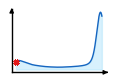

‚úÖ Predicted Probability ÂàÜÂ∏ÉÂõæÂ∑≤‰øùÂ≠òÂà∞: figure\US_figure\predicted_prob_distribution.png
üìä ÊÄªÊ†∑Êú¨: 64,982 | NegativeÊ†∑Êú¨: 2,538 | ÂùáÂÄº: 0.738


In [17]:
def visualize_predicted_prob_distribution(merged_data_for_plot, save_path=r'figure\US_figure\US_workflow\predicted_prob_distribution.png'):
    """
    ÂèÇÁÖß visualize_similarity ÁöÑËÆæÁΩÆÁªòÂà∂ predicted_prob ÂàÜÂ∏ÉÊõ≤Á∫ø
    - ‰∏çÊòæÁ§∫XËΩ¥‰∏éYËΩ¥ÁöÑtick‰∏élabel
    - ÂèÇÁÖß figsize ËÆæÁΩÆ
    - ÁªòÂà∂ÂàÜÂ∏ÉÊõ≤Á∫øÂíåÈò¥ÂΩ±
    - Ê†áËÆ∞ negative_sample ÁöÑÁÇπ
    """
    from scipy import stats
    
    # ÊèêÂèñ predicted_prob Êï∞ÊçÆ
    predicted_prob = merged_data_for_plot['predicted_prob'].dropna()
    
    # ÂàÜÁ¶ª negative_sample Êï∞ÊçÆ
    neg_samples = merged_data_for_plot[merged_data_for_plot['sample_type'] == 'negative_sample']
    neg_prob = neg_samples['predicted_prob'].dropna()
    
    # ËÆæÁΩÆÈ¢úËâ≤ÔºàÂèÇÁÖß visualize_similarityÔºâ
    curve_color = '#1565C0'  # Ê∑±ËìùËâ≤
    fill_color = '#B3E5FC'   # Ê∑°ËìùËâ≤
    neg_color = '#E31A1C'    # Á∫¢Ëâ≤ÔºàÊ†áËÆ∞negative_sampleÔºâ
    
    # ËÆæÁΩÆÂõæÂΩ¢ÂèÇÊï∞ÔºàÂèÇÁÖß visualize_similarityÔºâ
    fig, ax = plt.subplots(1, 1, figsize=(30/25.4, 20/25.4))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 6
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.labelcolor'] = 'black'
    plt.rcParams['ytick.labelcolor'] = 'black'
    
    # Êï∞ÊçÆË£ÅÂâ™ÔºàÂèÇÁÖß visualize_similarity ÁöÑ _hist_bins_clip ÈÄªËæëÔºâ
    pct_lo, pct_hi = 0.5, 99.5
    lo, hi = np.percentile(predicted_prob, [pct_lo, pct_hi])
    prob_clip = np.clip(predicted_prob, lo, hi)
    
    # ËÆ°ÁÆóKDEÂíåÁªòÂà∂Êõ≤Á∫ø
    kde = stats.gaussian_kde(prob_clip)
    x_min, x_max = np.min(prob_clip), np.max(prob_clip)
    x = np.linspace(x_min, x_max, 500)
    y = kde(x)
    
    # ÁªòÂà∂ÂàÜÂ∏ÉÊõ≤Á∫ø
    ax.plot(x, y, color=curve_color, linewidth=1, label='Predicted Probability Distribution')
    
    # ÁªòÂà∂Èò¥ÂΩ±Âå∫Âüü
    ax.fill_between(x, 0, y, color=fill_color, alpha=0.5)
    
    # Ê†áËÆ∞ negative_sample ÁöÑÁÇπ
    if len(neg_prob) > 0:
        # Âú®ÂàÜÂ∏ÉÊõ≤Á∫ø‰∏äÊ†áËÆ∞ negative_sample ÁöÑ‰ΩçÁΩÆ
        neg_y = kde(neg_prob)
        ax.scatter(neg_prob, neg_y, color=neg_color, s=8, alpha=0.8, 
                  marker='x', label='Negative Samples', zorder=10)
    
    # ËÆæÁΩÆËÉåÊôØÈ¢úËâ≤ÔºàÂèÇÁÖß visualize_similarityÔºâ
    fig = ax.get_figure()
    
    # ‰øÆÊîπÔºöÂáèÂ∞ëÁÅ∞Ëâ≤Âå∫ÂüüÔºåËÆ©ÂõæÂΩ¢Êõ¥Á¥ßÂáë
    ax.set_position([0.05, 0.05, 0.9, 0.9])  # ÁïôÂá∫10%ÁöÑËæπË∑ù
    
    # ‰∏çÊòæÁ§∫ÁΩëÊ†º
    ax.grid(False)
    
    # ËÆæÁΩÆÂàªÂ∫¶ÂèÇÊï∞ÔºàÂèÇÁÖß visualize_similarityÔºâ
    ax.tick_params(axis='both', which='major', width=0.5, length=2, labelsize=6, color='black')
    
    # ‰øÆÊîπÔºöËøûÊé•xËΩ¥‰∏éyËΩ¥ÔºåÊòæÁ§∫Â∫ïÈÉ®ÂíåÂ∑¶‰æßËæπÊ°Ü
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)  # ÊòæÁ§∫Â∫ïÈÉ®ËæπÊ°Ü
    ax.spines['left'].set_visible(True)    # ÊòæÁ§∫Â∑¶‰æßËæπÊ°Ü
    
    # ËÆæÁΩÆËæπÊ°ÜÈ¢úËâ≤ÂíåÂÆΩÂ∫¶
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    
    # ‰∏çÊòæÁ§∫XËΩ¥‰∏éYËΩ¥ÁöÑtick‰∏élabelÔºàÂèÇÁÖß visualize_similarityÔºâ
    ax.set_yticks([])
    ax.set_xticks([])
    
    # ‰øÆÊîπÔºöË∞ÉÊï¥ÁÆ≠Â§¥‰ΩçÁΩÆÔºåËÆ©ÂÆÉ‰ª¨‰ªéÂùêÊ†áËΩ¥Êú´Á´ØÂºÄÂßã
    ax.annotate('', xy=(1.02, 0), xycoords='axes fraction', xytext=(0.98, 0),
                arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True))
    ax.annotate('', xy=(0, 1.02), xycoords='axes fraction', xytext=(0, 0.98),
                arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True))
    
    # ‰øÆÊîπÔºö‰ΩøÁî®Êõ¥Á¥ßÂáëÁöÑÂ∏ÉÂ±Ä
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    
    # ‰øùÂ≠òÂõæÁâá
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
    print(f"‚úÖ Predicted Probability ÂàÜÂ∏ÉÂõæÂ∑≤‰øùÂ≠òÂà∞: {save_path}")
    
    # ÁÆÄÂåñÁöÑÁªüËÆ°‰ø°ÊÅØ
    print(f"üìä ÊÄªÊ†∑Êú¨: {len(predicted_prob):,} | NegativeÊ†∑Êú¨: {len(neg_prob):,} | ÂùáÂÄº: {np.mean(prob_clip):.3f}")
    
    return {
        "mean": np.mean(prob_clip),
        "std": np.std(prob_clip),
        "neg_samples_count": len(neg_prob),
        "total_samples_count": len(predicted_prob)
    }

# ‰ΩøÁî®ÂáΩÊï∞ÁªòÂà∂ÂàÜÂ∏É
if 'merged_data_for_plot' in locals():
    result = visualize_predicted_prob_distribution(
        merged_data_for_plot, 
        save_path=r'figure\US_figure\predicted_prob_distribution.png'
    )
else:
    print("‚ö†Ô∏è ËØ∑ÂÖàÁ°Æ‰øù merged_data_for_plot ÂèòÈáèÂ∑≤ÂÆö‰πâ")

# Á¢≥Ê±áÈÉ®ÂàÜÈôÑÂõæ

## Probability allocating 

In [ ]:
ds_new.landcover_at_abandonment.plot()
plt.title("Landcover at Abandonment (raw)")
plt.show()

[window] center snapped to ~ lat=36.862, lon=-120.621 (deg)
[window] unique classes in 12√ó12: [2 3 4]
[aggregation] window 12√ó12 ‚Üí grid_size=4 ‚Üí output 3√ó3


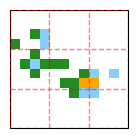

‚úÖ Â∑≤‰øùÂ≠ò: figure/US_figure/US_workflow\landcover_original_with_grid.png
[Type 4] counts range: 0.0 - 1.0
[Type 4] counts shape: (3, 3)


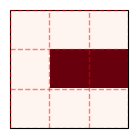

‚úÖ Â∑≤‰øùÂ≠ò: figure/US_figure/US_workflow\landcover_type4_counts_with_grid.png
[Type 2] counts range: 0.0 - 5.0
[Type 2] counts shape: (3, 3)


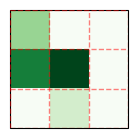

‚úÖ Â∑≤‰øùÂ≠ò: figure/US_figure/US_workflow\landcover_type2_counts_with_grid.png
[Type 3] counts range: 0.0 - 2.0
[Type 3] counts shape: (3, 3)


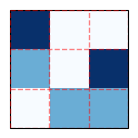

‚úÖ Â∑≤‰øùÂ≠ò: figure/US_figure/US_workflow\landcover_type3_counts_with_grid.png


In [28]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from tqdm.auto import tqdm

# ---------- Â∞èÂ∑•ÂÖ∑ÔºöÁªèÂ∫¶Ê†áÂáÜÂåñ & ÂúÜÂΩ¢Ë∑ùÁ¶ª argmin ----------
def _lon_to_180(lon):
    """Êää‰ªªÊÑèÁªèÂ∫¶Êï∞ÁªÑËßÑËåÉÂà∞ [-180, 180)"""
    lon = np.asarray(lon, dtype=float)
    return ((lon + 180.0) % 360.0) - 180.0

def _argmin_circular(lon_array_deg, target_deg):
    """
    Âú®ÁéØÂΩ¢(360¬∞)‰∏äÊâæ‰∏é target_deg ÊúÄËøëÁöÑÂÖÉÁ¥†Á¥¢Âºï
    Êó†ËÆ∫ lon ÊòØ 0‚Äì360 ËøòÊòØ -180‚Äì180 ÈÉΩËÉΩÊ≠£Á°ÆËøîÂõû
    """
    lon_std = _lon_to_180(lon_array_deg)
    t = _lon_to_180(target_deg)
    d = np.abs(lon_std - t)
    d = np.minimum(d, 360.0 - d)
    return int(np.nanargmin(d))

# ---------- 1) ‰∏•Ê†º 50√ó50 Á™óÂè£Ôºà‰ΩøÁî®sliceÊñπÊ≥ïÔºâ ----------
def extract_window_50x50(ds, var='landcover_at_abandonment',
                         center_lat=39.0, center_lon=-116.0, size=50):
    da = ds[var]
    lat_vals = da['lat'].values
    lon_vals = da['lon'].values

    # ÁªèÂ∫¶Áî®"ÂúÜÂΩ¢Ë∑ùÁ¶ª"ÂèñÊúÄËøëÁ¥¢ÂºïÔºåÁ∫¨Â∫¶Áõ¥Êé•ÂèñÊúÄËøëÁ¥¢Âºï
    i0 = int(np.argmin(np.abs(lat_vals - center_lat)))
    j0 = _argmin_circular(lon_vals, center_lon)

    half = size // 2
    i_start = max(0, i0 - half)
    i_end   = min(len(lat_vals), i_start + size)
    j_start = max(0, j0 - half)
    j_end   = min(len(lon_vals), j_start + size)

    # Ëã•Ëß¶ËæπÔºåÂèçÂêëË°•ÈΩêÁ™óÂè£Â§ßÂ∞è
    if (i_end - i_start) < size:
        i_start = max(0, i_end - size)
    if (j_end - j_start) < size:
        j_start = max(0, j_end - size)

    # ‰ΩøÁî®sliceÊñπÊ≥ïËÄå‰∏çÊòØÂ∏ÉÂ∞îÁ¥¢Âºï
    ds_win = ds.isel(lat=slice(i_start, i_end), lon=slice(j_start, j_end))

    # ËØäÊñ≠ÔºöÊä•ÂëäÁ™óÂè£‰∏≠ÂøÉÁöÑÁúüÂÆûÁªèÁ∫¨Â∫¶
    lat_c = float(ds_win['lat'].values[size//2])
    lon_c = float(_lon_to_180(ds_win['lon'].values[size//2]))
    print(f"[window] center snapped to ~ lat={lat_c:.3f}, lon={lon_c:.3f} (deg)")

    return ds_win

# ---------- 2) ÊääÂàÜÁ±ªÂÄºËßÑËåÉÂà∞ 1‚Äì9 ÁöÑÊï¥Êï∞ ----------
def _prepare_classes_1to9(da):
    """
    Â∞Ü da ËßÑËåÉ‰∏∫ 1‚Äì9 ÁöÑÊï¥Êï∞ÂàÜÁ±ªÔºåËåÉÂõ¥Â§ñËßÜ‰Ωú NaN„ÄÇ
    ÈÄÇÂêàÂêéÁª≠Á≠âÂÄºÊØîËæÉ‰∏éËÆ°Êï∞„ÄÇ
    """
    arr = np.array(da.values, dtype=float)
    # Ëã•Êúâ scale/offset ÂØºËá¥Âá∫Áé∞ 1.0000001 ‰πãÁ±ªÔºåÂÖàÂõõËàç‰∫îÂÖ•
    arr = np.rint(arr)
    # ËåÉÂõ¥Â§ñÁΩÆ NaN
    arr[(arr < 1) | (arr > 9)] = np.nan
    # ËΩ¨Âõû int16ÔºàNaN ÈúÄË¶Å floatÔºåÂõ†Ê≠§‰øùÊåÅ floatÔºåÂêéÁª≠ where/ËÆ°Êï∞‰∏çÂèóÂΩ±ÂìçÔºâ
    return xr.DataArray(arr, coords=da.coords, dims=da.dims, name=da.name)

# ---------- 3) ËÆ°Êï∞/ÂØÜÂ∫¶ÔºàÂú®Á™óÂè£‰∏äÊâßË°åÔºâ ----------
def calculate_counts(ds, value=None, grid_size=10, var='landcover_at_abandonment'):
    da = _prepare_classes_1to9(ds[var])
    if value is None:
        mask = xr.where(np.isfinite(da), 1.0, 0.0)
    else:
        mask = xr.where(np.isfinite(da) & (da == float(value)), 1.0, 0.0)

    # 50√ó50 -> 10√ó10ÔºàÊØè‰∏™ coarse ÂçïÂÖÉ 5√ó5Ôºâ
    counts = mask.coarsen(lon=grid_size, lat=grid_size, boundary='trim').sum()
    return counts

def calculate_weighted_densities(ds, grid_size=10, var='landcover_at_abandonment'):
    ds_density = xr.Dataset()
    total = calculate_counts(ds, value=None, grid_size=grid_size, var=var)
    ds_density['total_counts'] = total
    for value in tqdm(range(1, 10), desc='Calculating weighted densities'):
        c = calculate_counts(ds, value=value, grid_size=grid_size, var=var)
        ds_density[f'weighted_density_{value}'] = xr.where(total > 0, c/total, np.nan)
    return ds_density

# ‰øÆÊîπÁªòÂõæÂáΩÊï∞ÔºåÁ°Æ‰øùÁΩëÊ†ºÁ∫øÊ≠£Á°ÆÊòæÁ§∫
def plot_landcover_analysis_separate(ds, center_lat=39.0, center_lon=-116.0,
                                    size=50, save_dir='figure/US_figure/US_workflow'):
    os.makedirs(save_dir, exist_ok=True)

    # ‰∏•Ê†ºÁ™óÂè£
    ds_win = extract_window_50x50(ds, center_lat=center_lat, center_lon=center_lon, size=size)
    da_win = _prepare_classes_1to9(ds_win['landcover_at_abandonment'])

    # extent ‰∏é origin
    lat_arr = ds_win['lat'].values
    lon_arr = _lon_to_180(ds_win['lon'].values)
    lat_min, lat_max = float(lat_arr.min()), float(lat_arr.max())
    lon_min, lon_max = float(lon_arr.min()), float(lon_arr.max())
    extent = [lon_min, lon_max, lat_min, lat_max]
    origin = 'lower' if lat_arr[1] > lat_arr[0] else 'upper'

    # ËØäÊñ≠ÔºöÁ™óÂè£ÈáåÊúâ‰ªÄ‰πàÁ±ªÂà´Ôºü
    uniq = np.unique(da_win.values[~np.isnan(da_win.values)]).astype(int) if np.isfinite(da_win.values).any() else []
    print(f"[window] unique classes in {size}√ó{size}: {uniq}")

    # ËÆæÁΩÆÂõæÂΩ¢Â∞∫ÂØ∏‰∏∫30mm x 30mm
    figsize_mm = (30/25.4, 30/25.4)

    # Âä®ÊÄÅË∞ÉÊï¥ËÅöÂêàÂ§ßÂ∞èÔºöÁ°Æ‰øùËá≥Â∞ëÊúâ3√ó3ÁöÑÁΩëÊ†º
    grid_size = max(1, size // 3)  # 12‚Üí4, 30‚Üí10, 50‚Üí16
    print(f"[aggregation] window {size}√ó{size} ‚Üí grid_size={grid_size} ‚Üí output {size//grid_size}√ó{size//grid_size}")

    # ËÆ°ÁÆóËÅöÂêàÁΩëÊ†ºÁöÑËæπÁïåÁ∫ø
    def add_aggregation_grid(ax, lat_arr, lon_arr, grid_size, extent):
        """Âú®Âõæ‰∏äÊ∑ªÂä†ËÅöÂêàÁΩëÊ†ºÁöÑÁ∫¢Á∫øÊ°Ü"""
        # ËÆ°ÁÆóÁΩëÊ†ºËæπÁïå
        lat_step = (lat_max - lat_min) / len(lat_arr)
        lon_step = (lon_max - lon_min) / len(lon_arr)
        
        # ËÆ°ÁÆóËÅöÂêàÁΩëÊ†ºÁöÑËæπÁïåÁ∫ø
        grid_lat_lines = []
        grid_lon_lines = []
        
        # Á∫¨Â∫¶ËæπÁïåÁ∫ø
        for i in range(0, len(lat_arr), grid_size):
            if i < len(lat_arr):
                lat_val = lat_min + i * lat_step
                grid_lat_lines.append(lat_val)
        
        # ÁªèÂ∫¶ËæπÁïåÁ∫ø
        for j in range(0, len(lon_arr), grid_size):
            if j < len(lon_arr):
                lon_val = lon_min + j * lon_step
                grid_lon_lines.append(lon_val)
        
        # Ê∑ªÂä†ÊúÄÂêé‰∏ÄÊù°ËæπÁïåÁ∫ø
        grid_lat_lines.append(lat_max)
        grid_lon_lines.append(lon_max)
        
        # ÁªòÂà∂ÂûÇÁõ¥Á∫øÔºàÁªèÂ∫¶ÊñπÂêëÔºâ
        for lon_val in grid_lon_lines:
            ax.plot([lon_val, lon_val], [lat_min, lat_max], 'r--', 
                   linewidth=1, alpha=0.5, transform=ccrs.PlateCarree(), zorder=10)
        
        # ÁªòÂà∂Ê∞¥Âπ≥Á∫øÔºàÁ∫¨Â∫¶ÊñπÂêëÔºâ
        for lat_val in grid_lat_lines:
            ax.plot([lon_min, lon_max], [lat_val, lat_val], 'r--', 
                   linewidth=1, alpha=0.5, transform=ccrs.PlateCarree(), zorder=10)

    # ËÆ°ÁÆóÁ¨¶ÂêàËÅöÂêàÂàÜËæ®ÁéáÁöÑÁªèÁ∫¨ÁΩëÊ†º
    def add_resolution_grid(ax, lat_arr, lon_arr, grid_size, extent):
        """Add lat/lon grid lines at the native data resolution (lat[1]-lat[0], lon[1]-lon[0])"""
        # ËÆ°ÁÆóÂàÜËæ®Áéá
        if len(lat_arr) > 1:
            lat_res = abs(lat_arr[1] - lat_arr[0])
        else:
            lat_res = 0.1  # fallback
        
        if len(lon_arr) > 1:
            lon_res = abs(lon_arr[1] - lon_arr[0])
        else:
            lon_res = 0.1  # fallback

        # ËÆ°ÁÆóÁΩëÊ†ºÁ∫ø‰ΩçÁΩÆ
        lat_min, lat_max = min(lat_arr[0], lat_arr[-1]), max(lat_arr[0], lat_arr[-1])
        lon_min, lon_max = min(lon_arr[0], lon_arr[-1]), max(lon_arr[0], lon_arr[-1])

        # ÁîüÊàêÁªèÁ∫¨Â∫¶ÁΩëÊ†ºÁ∫ø
        grid_lat_lines = np.arange(lat_min, lat_max + lat_res, lat_res)
        grid_lon_lines = np.arange(lon_min, lon_max + lon_res, lon_res)

        # ÊöÇÊó∂‰∏çÁªòÂà∂

    # È¢úËâ≤Êò†Â∞Ñ
    classes = {
        1: ('Cropland',               'white'),
        2: ('Forest',                 '#228B22'),
        3: ('Savanna',                '#87CEFA'),  
        4: ('Shrub',                  '#FFA500'),
        5: ('Grassland & Arid',       '#DEB887'),
        6: ('Wetland',                '#8B4513'),
        7: ('Built-up',               '#87CEEB'),
        8: ('Bare & Ice',             '#FF6347'),
        9: ('Water',                  '#1E90FF'),
    }
    cmap = ListedColormap([classes[i][1] for i in range(1, 10)])

    # ---- Á¨¨‰∏ÄÂº†ÂõæÔºöÂéüÂßãÂàÜÁ±ªÔºàÂ∏¶ËÅöÂêàÁΩëÊ†ºÁ∫øÔºâ
    fig1, ax1 = plt.subplots(1, 1, figsize=figsize_mm, 
                             subplot_kw={'projection': ccrs.PlateCarree()})
    ax1.set_extent(extent, crs=ccrs.PlateCarree())
    
    data_plot = da_win.values.copy()
    data_plot[np.isnan(data_plot)] = 0
    
    im1 = ax1.imshow(data_plot, extent=extent, transform=ccrs.PlateCarree(),
                     cmap=cmap, vmin=1, vmax=9, origin=origin, interpolation='nearest', zorder=1)
    
    # Ê∑ªÂä†Á¨¶ÂêàËÅöÂêàÂàÜËæ®ÁéáÁöÑÁªèÁ∫¨ÁΩëÊ†º
    add_resolution_grid(ax1, lat_arr, lon_arr, grid_size, extent)
    
    # Ê∑ªÂä†ËÅöÂêàÁΩëÊ†ºÁ∫ø
    add_aggregation_grid(ax1, lat_arr, lon_arr, grid_size, extent)
    
    ax1.set_facecolor('white')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('')

    # Â°´Êª°Êï¥‰∏™figsize
    fig1.subplots_adjust(left=0, right=1, top=1, bottom=0)
    out1 = os.path.join(save_dir, 'landcover_original_with_grid.png')
    plt.savefig(out1, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    print(f'‚úÖ Â∑≤‰øùÂ≠ò: {out1}')

    # ---- Á¨¨‰∫åÂº†ÂõæÔºöType 4 countsÔºàÂ∏¶ËÅöÂêàÁΩëÊ†ºÁ∫øÔºâ
    fig2, ax2 = plt.subplots(1, 1, figsize=figsize_mm, 
                             subplot_kw={'projection': ccrs.PlateCarree()})
    ax2.set_extent(extent, crs=ccrs.PlateCarree())
    
    c4 = calculate_counts(ds_win, value=4, grid_size=grid_size)
    print(f"[Type 4] counts range: {c4.min().values:.1f} - {c4.max().values:.1f}")
    print(f"[Type 4] counts shape: {c4.shape}")
    
    im2 = ax2.imshow(c4.values, extent=extent, transform=ccrs.PlateCarree(),
                     cmap='Reds', origin=origin, interpolation='nearest', zorder=1)
    
    # Ê∑ªÂä†Á¨¶ÂêàËÅöÂêàÂàÜËæ®ÁéáÁöÑÁªèÁ∫¨ÁΩëÊ†º
    add_resolution_grid(ax2, lat_arr, lon_arr, grid_size, extent)
    
    # Ê∑ªÂä†ËÅöÂêàÁΩëÊ†ºÁ∫ø
    add_aggregation_grid(ax2, lat_arr, lon_arr, grid_size, extent)
    
    ax2.set_facecolor('#f0f0f0')
    ax2.add_feature(cfeature.STATES, linewidth=0.3, zorder=3)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title('')

    # Â°´Êª°Êï¥‰∏™figsize
    fig2.subplots_adjust(left=0, right=1, top=1, bottom=0)
    out2 = os.path.join(save_dir, 'landcover_type4_counts_with_grid.png')
    plt.savefig(out2, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    print(f'‚úÖ Â∑≤‰øùÂ≠ò: {out2}')

    # ---- Á¨¨‰∏âÂº†ÂõæÔºöType 2 countsÔºàÂ∏¶ËÅöÂêàÁΩëÊ†ºÁ∫øÔºâ
    fig3, ax3 = plt.subplots(1, 1, figsize=figsize_mm, 
                             subplot_kw={'projection': ccrs.PlateCarree()})
    ax3.set_extent(extent, crs=ccrs.PlateCarree())
    
    c2 = calculate_counts(ds_win, value=2, grid_size=grid_size)
    print(f"[Type 2] counts range: {c2.min().values:.1f} - {c2.max().values:.1f}")
    print(f"[Type 2] counts shape: {c2.shape}")
    
    im3 = ax3.imshow(c2.values, extent=extent, transform=ccrs.PlateCarree(),
                     cmap='Greens', origin=origin, interpolation='nearest', zorder=1)
    
    # Ê∑ªÂä†Á¨¶ÂêàËÅöÂêàÂàÜËæ®ÁéáÁöÑÁªèÁ∫¨ÁΩëÊ†º
    add_resolution_grid(ax3, lat_arr, lon_arr, grid_size, extent)
    
    # Ê∑ªÂä†ËÅöÂêàÁΩëÊ†ºÁ∫ø
    add_aggregation_grid(ax3, lat_arr, lon_arr, grid_size, extent)
    
    ax1.set_facecolor('white') 
    ax3.add_feature(cfeature.STATES, linewidth=0.3, zorder=3)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title('')

    # Â°´Êª°Êï¥‰∏™figsize
    fig3.subplots_adjust(left=0, right=1, top=1, bottom=0)
    out3 = os.path.join(save_dir, 'landcover_type2_counts_with_grid.png')
    plt.savefig(out3, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    print(f'‚úÖ Â∑≤‰øùÂ≠ò: {out3}')

    # ---- Á¨¨ÂõõÂº†ÂõæÔºöType 3 countsÔºàÂ∏¶ËÅöÂêàÁΩëÊ†ºÁ∫øÔºâ
    fig4, ax4 = plt.subplots(1, 1, figsize=figsize_mm, 
                             subplot_kw={'projection': ccrs.PlateCarree()})
    ax4.set_extent(extent, crs=ccrs.PlateCarree())
    
    c3 = calculate_counts(ds_win, value=3, grid_size=grid_size)
    print(f"[Type 3] counts range: {c3.min().values:.1f} - {c3.max().values:.1f}")
    print(f"[Type 3] counts shape: {c3.shape}")
    
    im4 = ax4.imshow(c3.values, extent=extent, transform=ccrs.PlateCarree(),
                     cmap='Blues', origin=origin, interpolation='nearest', zorder=1)
    
    # Ê∑ªÂä†Á¨¶ÂêàËÅöÂêàÂàÜËæ®ÁéáÁöÑÁªèÁ∫¨ÁΩëÊ†º
    add_resolution_grid(ax4, lat_arr, lon_arr, grid_size, extent)
    
    # Ê∑ªÂä†ËÅöÂêàÁΩëÊ†ºÁ∫ø
    add_aggregation_grid(ax4, lat_arr, lon_arr, grid_size, extent)
    
    ax1.set_facecolor('white') 
    ax4.add_feature(cfeature.STATES, linewidth=0.3, zorder=3)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_title('')

    # Â°´Êª°Êï¥‰∏™figsize
    fig4.subplots_adjust(left=0, right=1, top=1, bottom=0)
    out4 = os.path.join(save_dir, 'landcover_type3_counts_with_grid.png')
    plt.savefig(out4, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    print(f'‚úÖ Â∑≤‰øùÂ≠ò: {out4}')

    return ds_win


ds_new = xr.open_dataset('data/4.landcover_abd.nc')
_ = plot_landcover_analysis_separate(
        ds_new,
        center_lat=36.8633,
        center_lon=-120.6167,
        size=12,
        save_dir='figure/US_figure/US_workflow'
    )

## Carbon intensity yearly variation 

In [3]:
import pandas as pd
import numpy as np
df_analysis=pd.read_csv(r'data\US_data\df_merged_data_for_analysis.csv')
df_weight = pd.read_csv('data/US_data/df_weight.csv')



emission_intensity = pd.DataFrame({
    'year': ['2018',  '2030', '2035', '2040'],
    'CO2_g_per_kWh': [400.3,  302,  279.2, 261.1]
})
# Transform pv_transform (2020 emission factor) to 2030, 2040, 2050 using emission_intensity
pv_transform_2020 = 352  
# Interpolate emission intensity for 2020, 2030, 2040, 2050
years_target = [2020, 2030, 2040, 2050]
em_factors = np.interp(
    years_target,
    emission_intensity['year'].astype(int),
    emission_intensity['CO2_g_per_kWh']
)

# Calculate scaling factors relative to 2020
scaling_factors = em_factors / em_factors[0]

# ÁîüÊàê‰∏Ä‰∏™pv_transferÁöÑdataframe
pv_transfer = pd.DataFrame({
    'year': [2020, 2030, 2040, 2050],
    'pv_transform': [pv_transform_2020] + list(pv_transform_2020 * scaling_factors[1:])
})

# ËÆ°ÁÆóÊØè10Âπ¥Âå∫Èó¥ÁöÑÁ¥ØËÆ°ÂÖâ‰ºèËΩ¨ÂåñËÉΩÂäõÔºåÂπ∂ÊúÄÁªàÊ±áÊÄªÂà∞2050
years = [2020, 2030, 2040, 2050]

for idx in range(len(years)-1):
    y_start, y_end = years[idx], years[idx+1]
    pv_start = pv_transfer.loc[pv_transfer['year'] == y_start, 'pv_transform'].values[0]
    pv_end = pv_transfer.loc[pv_transfer['year'] == y_end, 'pv_transform'].values[0]
    # Á∫øÊÄßÊèíÂÄºÊØèÂπ¥pv_transformÔºåÁ¥ØËÆ°10Âπ¥
    pv_sum = 0
    for y in range(y_start, y_end):
        pv_y = pv_start + (pv_end - pv_start) * (y - y_start) / (y_end - y_start)
        pv_sum += df_analysis['E_yr_pixel'] * pv_y / 1000 / 1000 * 0.27 / (df_analysis['area_m2'] / 10000)
    df_analysis[f'pv_potential_{y_start}_{y_end-1}_sum'] = pv_sum

# Ê±áÊÄª2020-2050Á¥ØËÆ°ÂÄºÔºåÊ±áÊÄªsiteÁöÑÁ¥ØËÆ°ÂÖâ‰ºèÂáèÊéíËÉΩÂäõ(t C)
df_analysis['pv_potential_total(t)'] = sum(
    df_analysis[f'pv_potential_{years[i]}_{years[i+1]-1}_sum'] for i in range(len(years)-1)
)

df_analysis['power_generation_kwha'] = df_analysis['E_yr_pixel'] * 30 / df_analysis['area_m2'] * 10000
# emission_data = df_analysis[['lat', 'lon', 'Expectation_net_benefit_adjust','LNCS_expect','power_generation_kwha', 'area_m2']].copy()


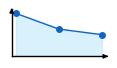

‚úÖ PV PotentialË∂ãÂäøÂõæÂ∑≤‰øùÂ≠òÂà∞: figure\US_figure\pv_potential_trend.png
üìä 2020-2029: 127,743,642.42
üìä 2030-2039: 104,385,602.45
üìä 2040-2049: 96,105,646.43


In [9]:
def plot_pv_potential_trend(df_analysis, save_path=r'figure\US_figure\pv_potential_trend.png'):
    """
    ÁªòÂà∂PV potentialÈöèÊó∂Èó¥ÂèòÂåñÁöÑË∂ãÂäøÊõ≤Á∫ø
    ‰ΩøÁî®‰∏é visualize_predicted_prob_distribution Áõ∏ÂêåÁöÑÂ≠ó‰ΩìÂíåÂõæÂΩ¢ËÆæÁΩÆ
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # ÂÆö‰πâÂèòÈáèÂàóË°®ÂíåÊó∂Èó¥Ê†áÁ≠æ
    varlist = ['pv_potential_2020_2029_sum', 'pv_potential_2030_2039_sum', 'pv_potential_2040_2049_sum']
    time_labels = ['2020-2029', '2030-2039', '2040-2049']
    
    # ËÆ°ÁÆóÊØè‰∏™ÂèòÈáèÁöÑÊÄªÂíå
    values = [df_analysis[var].sum() for var in varlist]
    
    # ËÆæÁΩÆÈ¢úËâ≤ÔºàÂèÇÁÖß visualize_predicted_prob_distributionÔºâ
    curve_color = '#1565C0'  # Ê∑±ËìùËâ≤
    fill_color = '#B3E5FC'   # Ê∑°ËìùËâ≤
    
    # ËÆæÁΩÆÂõæÂΩ¢ÂèÇÊï∞ÔºàÂèÇÁÖß visualize_predicted_prob_distributionÔºâ
    fig, ax = plt.subplots(1, 1, figsize=(30/25.4, 15/25.4))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 6
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.labelcolor'] = 'black'
    plt.rcParams['ytick.labelcolor'] = 'black'
    
    # ËÆ°ÁÆóyËΩ¥ËåÉÂõ¥Ôºö‰ªéÊúÄÂ§ßÂÄºÁöÑ1/2ÂºÄÂßã
    y_max = max(values)
    y_min = y_max * 0.5
    
    # ÁªòÂà∂Êõ≤Á∫ø
    x = np.arange(len(varlist))
    ax.plot(x, values, color=curve_color, linewidth=1, marker='o', markersize=4)
    
    # ÁªòÂà∂Èò¥ÂΩ±Âå∫ÂüüÔºà‰ªéy_minÂºÄÂßãÔºâ
    ax.fill_between(x, y_min, values, color=fill_color, alpha=0.5)
    
    # ËÆæÁΩÆyËΩ¥ËåÉÂõ¥
    ax.set_ylim(y_min, y_max * 1.05)  # È°∂ÈÉ®Áïô5%Á©∫Èó¥
    
    # ËÆæÁΩÆÂõæÂΩ¢‰ΩçÁΩÆ
    ax.set_position([0.05, 0.05, 0.9, 0.9])
    
    # ‰∏çÊòæÁ§∫ÁΩëÊ†º
    ax.grid(False)
    
    # ËÆæÁΩÆÂàªÂ∫¶ÂèÇÊï∞
    ax.tick_params(axis='both', which='major', width=0.5, length=2, labelsize=6, color='black')
    
    # ËÆæÁΩÆËæπÊ°Ü
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    
    # ‰∏çÊòæÁ§∫tickÂíålabelÔºàÂèÇÁÖßÂéüÂáΩÊï∞Ôºâ
    ax.set_yticks([])
    ax.set_xticks([])
    
    # Ê∑ªÂä†ÁÆ≠Â§¥
    ax.annotate('', xy=(1.02, 0), xycoords='axes fraction', xytext=(0.98, 0),
                arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True))
    ax.annotate('', xy=(0, 1.02), xycoords='axes fraction', xytext=(0, 0.98),
                arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True))
    
    # Ë∞ÉÊï¥Â∏ÉÂ±Ä
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    
    # ‰øùÂ≠òÂõæÁâá
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
    print(f"‚úÖ PV PotentialË∂ãÂäøÂõæÂ∑≤‰øùÂ≠òÂà∞: {save_path}")
    
    # ËæìÂá∫ÁªüËÆ°‰ø°ÊÅØ
    for label, val in zip(time_labels, values):
        print(f"üìä {label}: {val:,.2f}")
    
    return {
        "time_periods": time_labels,
        "values": values
    }

# ‰ΩøÁî®ÂáΩÊï∞ÁªòÂà∂Ë∂ãÂäøÂõæ
if 'df_analysis' in locals():
    result = plot_pv_potential_trend(
        df_analysis, 
        save_path=r'figure\US_figure\pv_potential_trend.png'
    )
else:
    print("‚ö†Ô∏è ËØ∑ÂÖàÁ°Æ‰øù df_analysis ÂèòÈáèÂ∑≤ÂÆö‰πâ")

# ÁªèÊµéÈÉ®ÂàÜÈôÑÂõæ

## ÊîøÁ≠ñÊÉÖÊôØÁ¥ØÁßØÂõæ

### Load data for economic 

In [3]:
import pandas as pd 
df_economic = pd.read_csv('data/US_data/df_economic.csv') 
df_economic

lat         lon pv_category      pv_model  \
0         31.320833 -105.929170          C1    REMIND 2.1   
1         31.329166 -105.929170          C1    REMIND 2.1   
2         31.337500 -105.937500          C1    REMIND 2.1   
3         31.337500 -105.929170          C1    REMIND 2.1   
4         31.345833 -105.937500          C1    REMIND 2.1   
...             ...         ...         ...           ...   
68880915  46.937500  -67.920830          C7  TIAM-ECN 1.1   
68880916  47.145832  -67.962500          C7  TIAM-ECN 1.1   
68880917  47.237500  -68.620834          C7  TIAM-ECN 1.1   
68880918  47.254166  -68.354164          C7  TIAM-ECN 1.1   
68880919  47.262500  -68.379166          C7  TIAM-ECN 1.1   

                   pv_scenario policy_category rcp_category   net_npv_usd  \
0         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364320e+06   
1         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364268e+06   
2         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364232e+06   
3         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364223e+06   
4         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364196e+06   
...                        ...             ...          ...           ...   
68880915        EN_NPi2100_COV             P1b       RCP8.5  4.447125e+06   
68880916        EN_NPi2100_COV             P1b       RCP8.5  4.148731e+06   
68880917        EN_NPi2100_COV             P1b       RCP8.5  4.294753e+06   
68880918        EN_NPi2100_COV             P1b       RCP8.5  4.331141e+06   
68880919        EN_NPi2100_COV             P1b       RCP8.5  4.147186e+06   

          net_cost_usd  analysis_year  
0         2.364320e+06           2020  
1         2.364268e+06           2020  
2         2.364232e+06           2020  
3         2.364223e+06           2020  
4         2.364196e+06           2020  
...                ...            ...  
68880915  4.654054e+06           2050  
68880916  4.654008e+06           2050  
68880917  4.654032e+06           2050  
68880918  4.654020e+06           2050  
68880919  4.654010e+06           2050  

[68880920 rows x 10 columns]

ÂêÑÊîøÁ≠ñÊÉÖÊôØ30Âπ¥ÊúüÈó¥Âπ≥ÂùáNPVÁªüËÆ°ÂàÜÊûê

P1 ÊîøÁ≠ñÊÉÖÊôØ:
  Âπ¥‰ªΩÊï∞Èáè: 4
  30Âπ¥Âπ≥ÂùáNPV: -1,995,805.12 USD/ha
  Ê†áÂáÜËØØ: 141,606.84 USD/ha
  95%ÁΩÆ‰ø°Âå∫Èó¥: [-2,273,354.52, -1,718,255.71] USD/ha
  ÂêÑÂπ¥‰ªΩÁªüËÆ°‰ø°ÊÅØ:
    2020: ÂùáÂÄº=-2,257,879.91, Ê†áÂáÜÂ∑Æ=483.45, Ê†∑Êú¨Êï∞=64982
    2030: ÂùáÂÄº=-2,198,755.93, Ê†áÂáÜÂ∑Æ=183,823.54, Ê†∑Êú¨Êï∞=64982
    2040: ÂùáÂÄº=-1,869,672.14, Ê†áÂáÜÂ∑Æ=298,824.51, Ê†∑Êú¨Êï∞=64982
    2050: ÂùáÂÄº=-1,656,912.50, Ê†áÂáÜÂ∑Æ=359,474.59, Ê†∑Êú¨Êï∞=64982

P2 ÊîøÁ≠ñÊÉÖÊôØ:
  Âπ¥‰ªΩÊï∞Èáè: 4
  30Âπ¥Âπ≥ÂùáNPV: -1,206,625.48 USD/ha
  Ê†áÂáÜËØØ: 384,612.53 USD/ha
  95%ÁΩÆ‰ø°Âå∫Èó¥: [-1,960,466.05, -452,784.92] USD/ha
  ÂêÑÂπ¥‰ªΩÁªüËÆ°‰ø°ÊÅØ:
    2020: ÂùáÂÄº=-2,133,221.85, Ê†áÂáÜÂ∑Æ=483.45, Ê†∑Êú¨Êï∞=64982
    2030: ÂùáÂÄº=-1,503,959.57, Ê†áÂáÜÂ∑Æ=261,028.71, Ê†∑Êú¨Êï∞=64982
    2040: ÂùáÂÄº=-793,570.25, Ê†áÂáÜÂ∑Æ=421,882.99, Ê†∑Êú¨Êï∞=64982
    2050: ÂùáÂÄº=-395,750.27, Ê†áÂáÜÂ∑Æ=503,598.57, Ê†∑Êú¨Êï∞=64982

P3 ÊîøÁ≠ñÊÉÖÊôØ:
  Âπ¥‰ªΩÊï∞È

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



‚úÖ ÂõæÁâáÂ∑≤‰øùÂ≠òÂà∞: figure\US_figure\US_workflow


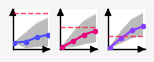

ÊîøÁ≠ñÊÉÖÊôØÂàÜÊûêÂÆåÊàêÔºÅ


In [8]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch
from matplotlib.collections import LineCollection
from scipy import stats
from scipy.stats import norm


def calculate_policy_scenarios(df_economic):
    """
    ËÆ°ÁÆóÈÉ®ÂàÜÔºöÂØπdf_economicËøõË°åÊîøÁ≠ñÂåπÈÖçÔºå‰∏∫ÊØè‰∏™ÂÉèÁ¥†ÁîüÊàêP1„ÄÅP2„ÄÅP3Êï∞ÊçÆ
    
    Parameters:
    -----------
    df_economic : DataFrame
        ÁªèÊµéÊï∞ÊçÆÔºåÂåÖÂê´policy_category, lat, lon, analysis_year, net_npv_usdÁ≠âÂ≠óÊÆµ
    
    Returns:
    --------
    dict : ÂåÖÂê´‰ª•‰∏ãÈîÆÂÄºÂØπÔºö
        - 'pixel_year_data': DataFrame with columns [policy_group, lat, lon, analysis_year, net_npv_usd]
        - 'policy_stats': dict with statistics for each policy (P1, P2, P3)
        - 'years': array of unique years
    """
    def match_policy(val):
        s = str(val)
        if 'P1' in s: return 'P1'
        if 'P2' in s: return 'P2'
        if 'P3' in s: return 'P3'
        return 'Other'
    
    # Â§çÂà∂Âπ∂ÂåπÈÖçÊîøÁ≠ñ
    df = df_economic.copy()
    df['policy_group'] = df['policy_category'].astype(str).apply(match_policy)
    df = df[df['policy_group'].isin(['P1', 'P2', 'P3'])]
    
    # Ëé∑ÂèñÂπ¥‰ªΩ
    years = np.sort(df['analysis_year'].unique())
    
    # ‰∏∫ÊØè‰∏™ÂÉèÁ¥†-Âπ¥‰ªΩËÆ°ÁÆóÂπ≥ÂùáÂÄºÔºàÂ§ÑÁêÜÂèØËÉΩÁöÑÈáçÂ§çÊï∞ÊçÆÔºâ
    pixel_year_data = (df.groupby(['policy_group', 'lat', 'lon', 'analysis_year'], as_index=False)
                          ['net_npv_usd'].mean())
    
    # ËÆ°ÁÆóÂêÑÊîøÁ≠ñÁöÑÁªüËÆ°‰ø°ÊÅØ
    policy_stats = {}
    policy_groups = ['P1', 'P2', 'P3']
    
    print("="*80)
    print("ÂêÑÊîøÁ≠ñÊÉÖÊôØ30Âπ¥ÊúüÈó¥Âπ≥ÂùáNPVÁªüËÆ°ÂàÜÊûê")
    print("="*80)
    
    for policy in policy_groups:
        py = pixel_year_data[pixel_year_data['policy_group'] == policy]
        
        if py.empty:
            policy_stats[policy] = None
            continue
        
        # ÊåâÂπ¥‰ªΩËÆ°ÁÆóÂùáÂÄº„ÄÅÊ†áÂáÜÂ∑ÆÂíåÊ†∑Êú¨Êï∞Èáè
        year_stats = py.groupby('analysis_year')['net_npv_usd'].agg(['mean', 'std', 'count'])
        year_stats = year_stats.reindex(years)
        
        year_means = year_stats['mean']
        year_stds = year_stats['std']
        year_ns = year_stats['count']
        
        # ËÆ°ÁÆó30Âπ¥ÊúüÈó¥ÁöÑÁªüËÆ°Èáè
        overall_mean = year_means.mean()
        overall_std = year_means.std(ddof=1)
        n_years = len(years)
        standard_error = overall_std / np.sqrt(n_years)
        confidence_interval_95 = 1.96 * standard_error
        
        # ÂàÜ‰ΩçÊï∞ËÆ°ÁÆó
        quantiles = py.groupby('analysis_year')['net_npv_usd'].quantile([0.25, 0.75]).unstack()
        quantiles = quantiles.reindex(years)
        
        # Â≠òÂÇ®ÁªüËÆ°ÁªìÊûúÔºàÊ∑ªÂä†year_stdsÂíåyear_nsÔºâ
        policy_stats[policy] = {
            'n_years': n_years,
            'overall_mean': overall_mean,
            'overall_std': overall_std,
            'standard_error': standard_error,
            'ci_95_lower': overall_mean - confidence_interval_95,
            'ci_95_upper': overall_mean + confidence_interval_95,
            'year_means': year_means,
            'year_stds': year_stds,      # Êñ∞Â¢ûÔºöÊØèÂπ¥ÁöÑÊ†áÂáÜÂ∑Æ
            'year_ns': year_ns,          # Êñ∞Â¢ûÔºöÊØèÂπ¥ÁöÑÊ†∑Êú¨Êï∞Èáè
            'quantiles': quantiles
        }
        
        # ÊâìÂç∞ÁªìÊûú
        print(f"\n{policy} ÊîøÁ≠ñÊÉÖÊôØ:")
        print(f"  Âπ¥‰ªΩÊï∞Èáè: {n_years}")
        print(f"  30Âπ¥Âπ≥ÂùáNPV: {overall_mean:,.2f} USD/ha")
        print(f"  Ê†áÂáÜËØØ: {standard_error:,.2f} USD/ha")
        print(f"  95%ÁΩÆ‰ø°Âå∫Èó¥: [{overall_mean - confidence_interval_95:,.2f}, "
              f"{overall_mean + confidence_interval_95:,.2f}] USD/ha")
        
        # ÊâìÂç∞ÂêÑÂπ¥‰ªΩÁöÑÁªüËÆ°‰ø°ÊÅØ
        print(f"  ÂêÑÂπ¥‰ªΩÁªüËÆ°‰ø°ÊÅØ:")
        for year in years:
            mean_val = year_means.get(year, np.nan)
            std_val = year_stds.get(year, np.nan)
            n_val = year_ns.get(year, 0)
            print(f"    {year}: ÂùáÂÄº={mean_val:,.2f}, Ê†áÂáÜÂ∑Æ={std_val:,.2f}, Ê†∑Êú¨Êï∞={int(n_val)}")
    
    # ÊîøÁ≠ñÈó¥ÊØîËæÉÂàÜÊûê
    print("\n" + "="*80)
    print("ÊîøÁ≠ñÊÉÖÊôØÈó¥ÊØîËæÉÂàÜÊûê")
    print("="*80)
    
    valid_policies = {k: v for k, v in policy_stats.items() if v is not None}
    
    if len(valid_policies) > 1:
        sorted_policies = sorted(valid_policies.items(), 
                               key=lambda x: x[1]['overall_mean'], 
                               reverse=True)
        
        print("\nÊåâ30Âπ¥Âπ≥ÂùáNPVÊéíÂ∫è:")
        for i, (policy, stats) in enumerate(sorted_policies, 1):
            print(f"  {i}. {policy}: {stats['overall_mean']:,.2f} ¬± {stats['standard_error']:,.2f} USD/ha")
        
        print("\nÊîøÁ≠ñÈó¥Â∑ÆÂºÇÂàÜÊûê:")
        policy_names = list(valid_policies.keys())
        for i in range(len(policy_names)):
            for j in range(i+1, len(policy_names)):
                policy1, policy2 = policy_names[i], policy_names[j]
                stats1, stats2 = valid_policies[policy1], valid_policies[policy2]
                
                mean_diff = stats1['overall_mean'] - stats2['overall_mean']
                se_diff = np.sqrt(stats1['standard_error']**2 + stats2['standard_error']**2)
                t_stat = mean_diff / se_diff
                p_value = 2 * (1 - norm.cdf(abs(t_stat)))
                
                print(f"  {policy1} vs {policy2}: {mean_diff:+,.2f} ¬± {se_diff:,.2f} USD/ha")
                print(f"    t-stat: {t_stat:.3f}, p-value: {p_value:.4f}")
                
                if p_value < 0.001:
                    significance = "***"
                elif p_value < 0.01:
                    significance = "**"
                elif p_value < 0.05:
                    significance = "*"
                else:
                    significance = "ns"
                print(f"    ÊòæËëóÊÄß: {significance}")
    
    print("\n" + "="*80)
    
    return {
        'pixel_year_data': pixel_year_data,
        'policy_stats': policy_stats,
        'years': years
    }

def plot_policy_scenarios(calculation_results, save_dir=r'figure\US_figure\US_workflow'):
    """
    ÁªòÂõæÈÉ®ÂàÜÔºöÂü∫‰∫éËÆ°ÁÆóÁªìÊûúÁªòÂà∂ÊîøÁ≠ñÊÉÖÊôØÂàÜÊûêÂõæÔºàÊûÅÁÆÄÁâàÊú¨Ôºâ
    
    Parameters:
    -----------
    calculation_results : dict
        calculate_policy_scenariosÂáΩÊï∞ÁöÑËæìÂá∫ÁªìÊûú
    save_dir : str
        ÂõæÁâá‰øùÂ≠òÁõÆÂΩï
    
    Returns:
    --------
    fig, axes : matplotlib figure and axes objects
    """
    pixel_year_data = calculation_results['pixel_year_data']
    policy_stats = calculation_results['policy_stats']
    years = calculation_results['years']
    
    policy_groups = ['P1', 'P2', 'P3']
    
    # ËÆæÁΩÆÂ≠ó‰Ωì‰∏∫Arial
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # ÊÄªfigsize: 45mm x 15mm = 45/25.4 x 15/25.4 inches
    fig, axes = plt.subplots(1, 3, figsize=(45/25.4, 12/25.4), sharex=True)
    
    # ËÆæÁΩÆÊï¥‰∏™ÁîªÂ∏ÉËÉåÊôØ‰∏∫ÁÅ∞Ëâ≤
    fig.patch.set_facecolor('#f5f5f5')  # ÊµÖÁÅ∞Ëâ≤
    
    # È¢úËâ≤ÊñπÊ°à
    colors = {
        'P1': dict(mean='#4E4EFF', ci='#6B6BFF', pixel='#BBBBBB', 
                   band_75='#E6E6FF'),
        'P2': dict(mean='#E6007A', ci='#FF4FA3', pixel='#BBBBBB', 
                   band_75='#F9D1E6'),
        'P3': dict(mean='#8B3EFF', ci='#B266FF', pixel='#BBBBBB', 
                   band_75='#E6D6FF')
    }
    
    for i, (ax, policy) in enumerate(zip(axes, policy_groups)):

        # ËÆæÁΩÆÊØè‰∏™Â≠êÂõæÁöÑËÉåÊôØ‰∏∫ÁôΩËâ≤
        ax.set_facecolor('white')
        left = 0.1 + i * 0.3  # Ê†πÊçÆÂ≠êÂõæÁ¥¢ÂºïË∞ÉÊï¥Â∑¶‰æß‰ΩçÁΩÆ
        ax.set_position([left, 0.2, 0.25, 0.6]) 
        py = pixel_year_data[pixel_year_data['policy_group'] == policy]
        stats = policy_stats.get(policy)

        if py.empty or stats is None:
            ax.text(0.5, 0.5, f'No data for {policy}', 
                   ha='center', va='center', transform=ax.transAxes)
            continue

        # ÂÉèÁ¥†Êõ≤Á∫øÔºàÊûÅ‰ΩéÈÄèÊòéÂ∫¶Ôºâ
        pivot = (py.pivot_table(index=['lat', 'lon'], columns='analysis_year',
                                values='net_npv_usd', aggfunc='mean')
                 .reset_index())
        
        segs = []
        for _, row in pivot.iterrows():
            xs, ys = [], []
            for y in years:
                v = row.get(y, np.nan)
                if pd.notna(v):
                    xs.append(float(y))
                    ys.append(float(v))
            if len(xs) > 1:
                segs.append(np.column_stack([xs, ys]))
        
        if segs:
            lc = LineCollection(segs, colors=colors[policy]['pixel'],
                                linewidths=0.25, alpha=0.04, zorder=1)
            lc.set_rasterized(True)
            ax.add_collection(lc)
        
        # 95% CI for mean (assuming t-distribution)
        year_means = stats['year_means']
        year_stds = stats['year_stds']
        year_ns = stats['year_ns']
        x_ci = years
        mu = year_means.values

        # Calculate 95% CI using t-distribution
        from scipy.stats import t
        ci_low = []
        ci_high = []
        for mean, std, n in zip(year_means.values, year_stds.values, year_ns.values):
            if n > 1 and not np.isnan(std):
                tval = t.ppf(0.975, n-1)
                se = std / np.sqrt(n)
                ci_low.append(mean - tval * se)
                ci_high.append(mean + tval * se)
            else:
                ci_low.append(np.nan)
                ci_high.append(np.nan)
        ci_low = np.array(ci_low)
        ci_high = np.array(ci_high)

        ax.fill_between(x_ci, ci_low, ci_high, color=colors[policy]['band_75'], 
                        alpha=1, zorder=3, linewidth=0)

        # ÂùáÂÄºÁ∫ø
        mean_line, = ax.plot(x_ci, mu, color=colors[policy]['mean'], linewidth=1.5,
                             marker='o', markersize=3, zorder=12)
        # ‰∏çÊòæÁ§∫Ê†áÈ¢ò
        # ax.set_title() - ÁßªÈô§
        
        # ÁΩëÊ†º
        ax.grid(True, alpha=0.25, linewidth=0.3, zorder=0)
        ax.set_axisbelow(True)
        
        # 0Á∫ø
        ax.axhline(0, color='#FF1744', linestyle='--', linewidth=1, alpha=0.8, zorder=20)
        
        # Êô∫ËÉΩyËΩ¥ËåÉÂõ¥
        vals = py['net_npv_usd'].to_numpy()
        data_min, data_max = np.nanmin(vals), np.nanmax(vals)
        q01, q99 = np.nanpercentile(vals, [1, 99])
        
        if policy == 'P1':
            lo = min(q01, data_min) - 0.1e6
            hi = max(q99, 0.1e6) + 0.2e6
            ax.set_ylim(lo, hi)
        elif policy == 'P2':
            lo = min(q01, data_min) - 0.2e6
            hi = max(data_min, data_max) + 0.1e6
            ax.set_ylim(lo, hi)
        elif policy == 'P3':
            lo = min(data_min, -0.5e6) - 0.3e6
            hi = max(q99, data_max) + 0.15e6
            ax.set_ylim(lo, hi)
        
        # ÁßªÈô§ÊâÄÊúâÂàªÂ∫¶ÂíåÊ†áÁ≠æ
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        # Âú®x‰∏éyËΩ¥ÁöÑÊú´Á´ØÂä†ÂÖ•ÁÆ≠Â§¥
        # xËΩ¥ÁÆ≠Â§¥
        ax.annotate(
            '', 
            xy=(1.02, 0), xycoords='axes fraction', 
            xytext=(0.98, 0), 
            arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True)
        )
        # yËΩ¥ÁÆ≠Â§¥
        ax.annotate(
            '', 
            xy=(0, 1.02), xycoords='axes fraction', 
            xytext=(0, 0.98), 
            arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True)
        )
        
        # ‰∏çÊòæÁ§∫Âõæ‰æã
        # ax.legend() - ÁßªÈô§
    
    # ‰∏çÊòæÁ§∫xÂíåyÁöÑÊ†áÁ≠æ
    # axes[0].set_ylabel() - ÁßªÈô§
    
    # ËæπÊ°ÜËÆæÁΩÆ
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        for side in ['left', 'bottom']:
            ax.spines[side].set_linewidth(1)
            ax.spines[side].set_color('black')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.3)
    
    # ‰øùÂ≠òÂõæÁâá
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    fig.savefig(f'{save_dir}/Figure_policy_scenarios_analysis.eps', 
                bbox_inches='tight', dpi=300, format='eps')
    fig.savefig(f'{save_dir}/Figure_policy_scenarios_analysis.png', 
                bbox_inches='tight', dpi=300, format='png')
    
    print(f"\n‚úÖ ÂõæÁâáÂ∑≤‰øùÂ≠òÂà∞: {save_dir}")
    
    return fig, axes


# ‰ΩøÁî®Á§∫‰æã
# Á¨¨‰∏ÄÊ≠•ÔºöËÆ°ÁÆó
calculation_results = calculate_policy_scenarios(df_economic)

# Á¨¨‰∫åÊ≠•ÔºöÁªòÂõæ
fig_policy, axes_policy = plot_policy_scenarios(
    calculation_results, 
    save_dir=r'figure\US_figure\US_workflow'
)

plt.show()


print("ÊîøÁ≠ñÊÉÖÊôØÂàÜÊûêÂÆåÊàêÔºÅ")

## Êú∫‰ºöÊàêÊú¨Êü±Áä∂Âõæ


ÂÖ∂ÂÆûËøô‰∏™ÂÄº‰∏ªË¶ÅÂèòÂä®ÁöÑÂ∞±ÊòØAgriculturalÂÄºÔºåÂÖ∂‰Ωô‰∏§‰∏™ÂÄºforset„ÄÅnaturalÂÆûÈôÖ‰∏äÈÉΩ‰∏ç‰ºöÂèòÂä®ÔºàËÄå‰∏îÈÉΩ‰∏∫Ë¥üÊï∞Ôºâ„ÄÇ

Âõ†Ê≠§ÊàëÊÄùËÄÉ‰∫Ü‰∏ãÔºåÊîπÂèò‰∏Ä‰∏ãËøô‰∏™ÂõæÁöÑÁªÑÁªáÂΩ¢ÂºèÔºåÂèòÊàêÔºöÊï£ÁÇπÂõæÔºàÂú®ÊØè‰∏™ÊîøÁ≠ñGroup‰∏≠ÔºåÊ†πÊçÆstateÂÜçËÆ°ÁÆómeanÔºåÂπ∂‰∏îÁî®stateÊâÄÂ±û‰∫éÁöÑ‰∏çÂêå'A Climate Zone'ÂàÜÈÖçÂØπÂ∫îÊï∞ÊçÆÊ†áÁ≠æÔºâ+ Êü±Áä∂Â†ÜÁßØÂõæÔºàÊ≥®ÊÑèorset„ÄÅnaturalÊòØË¥üÊï∞ÁöÑÈÄÜÂêëÂ†ÜÁßØÔºåÁî®Êù•Â±ïÁ§∫‰∏ªË¶ÅÁöÑÊàêÊú¨ÁªìÊûÑÔºâ 

Ê†πÊçÆÊØè‰∏™pixelÂú®P2,P2,P3 group ËÆ°ÁÆóÂá∫Êù•ÁöÑ mean cost > 0 ËøõË°åÊï£ÁÇπÊ†áÊ≥®„ÄÇÊ†áÊ≥®‰ªñ‰ª¨Êù•Ëá™‰∫éÂì™‰∏™stateÂπ∂‰∏îÁî®È¢úËâ≤Ë°®Á§∫ÔºàÊ†áËÆ∞Ëøô‰∏™stateÂØπÂ∫îÁöÑÊï£ÁÇπÔºâ


ÈúÄË¶ÅÊ†πÊçÆÊåâÁÖßP1,P2,P3ËÅöÂêàÂêéÁîüÊàêÁöÑdfÔºåÊ†πÊçÆ'lat','lon'‰∏éus_states_4326ÊâßË°ågpd.sjoin„ÄÇÁÑ∂ÂêéÊåÇ‰∏äÂØπÂ∫îÂú∞ÁêÜËåÉÂõ¥ÁöÑus_states_4326['STUSPS'].unique()Âíådf_climate_zone['A Climate Zone'].unique()„ÄÇÂÖ∂‰∏≠Ôºåus_states_4326['STUSPS'].unique()ÈúÄË¶ÅÂÖàÂåπÈÖç‰∏ädf_climate_zone['State'].unique()ÂÄºÔºåÊâçËÉΩÊåÇ‰∏äA Climate ZoneÂ≠óÊÆµÔºàÂÖ∂‰∏≠ÔºåËØ∑‰Ω†Êää'Hot-Dry'‰∏é'Mixed-Dry'ÂêàÂπ∂Êàê'Dry'Ôºõ 'Cold'Âíå'Very Cold'ÂêàÂπ∂Êàê'cold'Ôºõ'Hot-Humid'Âíå'Mixed-Humid'ÂêàÂπ∂Êàê'Humid'ÔºåËøôÊ†∑ÊÄªÂÖ±Â∞±Êúâ5ÁßçÊï∞ÊçÆÊ†áÁ≠æÔºâ„ÄÇËØ∑‰Ω†ÊâßË°åÁöÑÊó∂ÂÄôÔºåÊâìÂç∞‰∏Ä‰∏ãÂåπÈÖçÊÉÖÂÜµ„ÄÇ



all_climate_zones = sorted(df_zone['BA Climate Zone'].unique())
all_climate_zones = [z for z in all_climate_zones if pd.notna(z)]
climate_colors = {
    'Hot-Dry': '#FF6B6B',
    'Mixed-Dry': '#FF8E8E', 
    'Cold': '#6C5CE7',
    'Very Cold': '#8A7FE8',
    'Hot-Humid': '#F9CA24',
    'Mixed-Humid': '#45B7D1',
    'Marine': '#4ECDC4',
    'Subarctic': '#A8E6CF'
}

In [ ]:
import pandas as pd

df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_agricultural_npv = pd.read_csv('data/US_data/df_agricultural_npv.csv')
df_afforestation_npv = pd.read_csv('data/US_data/df_afforestation_npv.csv')
df_natural_npv = pd.read_csv('data/US_data/df_natural_npv.csv')

NameError: name 'df_economic' is not defined

In [ ]:
df_climate_zone['State'].unique()

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UM', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI',
       'WV', 'WY'], dtype=object)

In [23]:
def create_opportunity_cost_unified(df_economic, df_agricultural_npv, df_afforestation_npv, df_natural_npv, 
                                    us_states_4326, df_climate_zone):
    """
    ‰ºòÂåñÁâàÊú∫‰ºöÊàêÊú¨ÂàÜÊûêÂõæÔºöÊï£ÁÇπÂõæ+Êü±Áä∂Â†ÜÁßØÂõæ
    ÈáçÁÇπ‰ºòÂåñËÆ°ÁÆóÊïàÁéá
    ÂéªÊéâÂèåYËΩ¥ÔºåÊâÄÊúâÂÜÖÂÆπÁªòÂà∂Âú®Âêå‰∏Ä‰∏ªÂùêÊ†áËΩ¥‰∏ä
    """
    
    # ËÆæÁΩÆÂ≠ó‰Ωì
    plt.rcParams['font.family'] = 'Arial'
    
    print("ÂºÄÂßã‰ºòÂåñÁâàÊú∫‰ºöÊàêÊú¨ÂàÜÊûê...")
    
    # 1. Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ - ÂêëÈáèÂåñÊìç‰Ωú
    print("1. Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ...")
    
    # RCPÊò†Â∞Ñ - ‰ΩøÁî®Â≠óÂÖ∏Êò†Â∞ÑÊõø‰ª£apply
    rcp_mapping = {
        'C1': 'RCP2.6', 'C2': 'RCP2.6', 'C3': 'RCP2.6',
        'C4': 'RCP4.5', 'C5': 'RCP6.0', 
        'C6': 'RCP8.5', 'C7': 'RCP8.5', 'C8': 'RCP8.5'
    }
    
    # 2. È´òÊïàÂ§ÑÁêÜdf_economic
    print("2. Â§ÑÁêÜÁªèÊµéÊï∞ÊçÆ...")
    
    # ‰ΩøÁî®ÂêëÈáèÂåñÊìç‰ΩúÊõø‰ª£apply
    df_economic_2050 = df_economic[df_economic['analysis_year'] == 2050].copy()
    
    # ÂêëÈáèÂåñRCPÊò†Â∞Ñ
    df_economic_2050['mapped_rcp'] = df_economic_2050['pv_category'].map(rcp_mapping)
    
    # ÂêëÈáèÂåñÊîøÁ≠ñÂàÜÁªÑ
    df_economic_2050['policy_group'] = df_economic_2050['policy_category'].str.extract(r'(P[123])')[0]
    
    # ËøáÊª§ÊúâÊïàÊï∞ÊçÆ
    valid_mask = df_economic_2050['policy_group'].isin(['P1', 'P2', 'P3'])
    df_economic_2050 = df_economic_2050[valid_mask]
    
    # 3. È´òÊïàËÅöÂêà - ‰ΩøÁî®groupby.agg‰∏ÄÊ¨°ÊÄßËÆ°ÁÆó
    print("3. Êï∞ÊçÆËÅöÂêà...")
    
    agg_cols = ['lat', 'lon', 'policy_category', 'policy_group', 'mapped_rcp']
    df_economic_agg = df_economic_2050.groupby(agg_cols).agg({
        'net_npv_usd': 'mean',
        'net_cost_usd': 'mean'
    }).reset_index()
    
    print(f"ËÅöÂêàÂêéÊï∞ÊçÆ: {len(df_economic_agg)} Ë°å")
    
    # 4. Â§ÑÁêÜÊú∫‰ºöÊàêÊú¨Êï∞ÊçÆ - ÂÖàÁªü‰∏ÄÂàóÂêçÂÜçÂ§ÑÁêÜ
    print("4. Â§ÑÁêÜÊú∫‰ºöÊàêÊú¨Êï∞ÊçÆ...")
    
    # ÂÖàÁªü‰∏ÄÂàóÂêç‰∏∫Â∞èÂÜôÔºåÈÅøÂÖçÂ§ßÂ∞èÂÜôÈóÆÈ¢ò
    opp_data = {}
    # tqdmÁî®‰∫éÊòæÁ§∫ËøõÂ∫¶Êù°
    for name, df in tqdm([('agri', df_agricultural_npv), ('affor', df_afforestation_npv), ('nat', df_natural_npv)], desc="Â§ÑÁêÜÊú∫‰ºöÊàêÊú¨Êï∞ÊçÆ"):
        df_temp = df.copy()
        # Áªü‰∏ÄÂàóÂêç‰∏∫Â∞èÂÜô
        df_temp.columns = df_temp.columns.str.lower()
        
        # Áé∞Âú®ÂèØ‰ª•ÂÆâÂÖ®Âú∞ËÆøÈóÆÂ∞èÂÜôÂàóÂêç
        df_temp = df_temp[df_temp['analysis_year'] == 2050][['lat', 'lon', 'rcp_category', 'cumulative_npv_usd']].copy()
        df_temp.columns = ['lat', 'lon', 'rcp_category', f'{name}_npv']
        opp_data[name] = df_temp
    
    # 5. È´òÊïàÂêàÂπ∂Êú∫‰ºöÊàêÊú¨Êï∞ÊçÆ
    print("5. ÂêàÂπ∂Êú∫‰ºöÊàêÊú¨Êï∞ÊçÆ...")
    
    # ‰ΩøÁî®reduceËøõË°åÂ§öË°®ÂêàÂπ∂
    from functools import reduce
    # tqdmÁî®‰∫éÊòæÁ§∫ÂêàÂπ∂ËøõÂ∫¶
    opp_data_list = list(opp_data.values())
    df_opp_merged = opp_data_list[0]
    for right in tqdm(opp_data_list[1:], desc="ÂêàÂπ∂Êú∫‰ºöÊàêÊú¨Êï∞ÊçÆ"):
        df_opp_merged = pd.merge(df_opp_merged, right, on=['lat', 'lon', 'rcp_category'], how='inner')
    
    print(f"ÂêàÂπ∂ÂêéÁöÑÊú∫‰ºöÊàêÊú¨Êï∞ÊçÆ: {len(df_opp_merged)} Ë°å")
    
    # 6. ÊúÄÁªàÂêàÂπ∂ - ‰ΩøÁî®merge_asof‰ºòÂåñÂ§ßÊï∞ÊçÆÈõÜÂêàÂπ∂
    print("6. ÊúÄÁªàÊï∞ÊçÆÂêàÂπ∂...")
    
    # ÂÖàÊéíÂ∫è‰ª•ÊèêÈ´òmergeÊïàÁéá
    df_economic_agg = df_economic_agg.sort_values(['lat', 'lon', 'mapped_rcp'])
    df_opp_merged = df_opp_merged.sort_values(['lat', 'lon', 'rcp_category'])
    
    df_final = pd.merge(df_economic_agg, df_opp_merged, 
                        left_on=['lat', 'lon', 'mapped_rcp'], 
                        right_on=['lat', 'lon', 'rcp_category'], 
                        how='inner')
    
    print(f"ÊúÄÁªàÊï∞ÊçÆ: {len(df_final)} Ë°å")
    
    # 7. Âú∞ÁêÜ‰ø°ÊÅØÂåπÈÖç - ‰ºòÂåñÁ©∫Èó¥ËøûÊé•
    print("7. Âú∞ÁêÜ‰ø°ÊÅØÂåπÈÖç...")
    
    # ÂàõÂª∫PointÂá†‰ΩïÂØπË±° - ÂêëÈáèÂåñ
    geometry = gpd.points_from_xy(df_final['lon'], df_final['lat'])
    gdf_final = gpd.GeoDataFrame(df_final, geometry=geometry, crs='EPSG:4326')
    
    # ‰ºòÂåñÁ©∫Èó¥ËøûÊé• - Âè™‰øùÁïôÂøÖË¶ÅÁöÑÂàó
    states_simple = us_states_4326[['STUSPS', 'geometry']].copy()
    
    # ÊâßË°åÁ©∫Èó¥ËøûÊé•
    gdf_with_states = gpd.sjoin(gdf_final, states_simple, how='left', predicate='within')
    
    # 8. Ê∞îÂÄôÂå∫ÂüüÂåπÈÖç - ‰ºòÂåñÂåπÈÖçÈÄªËæë
    print("8. Ê∞îÂÄôÂå∫ÂüüÂåπÈÖç...")
    
    # ÂàõÂª∫Â∑ûÂêçÊò†Â∞ÑÂ≠óÂÖ∏
    state_climate_map = dict(zip(df_climate_zone['State'], df_climate_zone['BA Climate Zone']))
    
    # Ê∞îÂÄôÂå∫ÂüüÂêàÂπ∂Êò†Â∞Ñ
    climate_merge_map = {
        'Hot-Dry': 'Dry', 'Mixed-Dry': 'Dry',
        'Cold': 'Cold', 'Very Cold': 'Cold',
        'Hot-Humid': 'Humid', 'Mixed-Humid': 'Humid',
        'Marine': 'Marine', 'Subarctic': 'Subarctic'
    }
    
    # ÂêëÈáèÂåñÊ∞îÂÄôÂå∫ÂüüÂåπÈÖç
    gdf_with_states['climate_zone'] = gdf_with_states['STUSPS'].map(state_climate_map)
    gdf_with_states['climate_zone_merged'] = gdf_with_states['climate_zone'].map(climate_merge_map)
    
    # ÊâìÂç∞ÂåπÈÖçÊÉÖÂÜµ
    print("Ê∞îÂÄôÂå∫ÂüüÂåπÈÖçÊÉÖÂÜµ:")
    print(gdf_with_states['climate_zone_merged'].value_counts())
    
    # 9. ËÆ°ÁÆóÂ∑ûÁ∫ßÂà´ÁöÑÁªüËÆ°Èáè
    print("9. ËÆ°ÁÆóÂ∑ûÁ∫ßÂà´ÁªüËÆ°Èáè...")
    
    # ÊåâÂ∑ûÂíåÊîøÁ≠ñÁªÑËÅöÂêàÔºåËÆ°ÁÆóÊØè‰∏™Â∑ûÁöÑÂπ≥ÂùáÊú∫‰ºöÊàêÊú¨
    state_policy_stats = gdf_with_states.groupby(['STUSPS', 'policy_group', 'climate_zone_merged']).agg({
        'agri_npv': 'mean',
        'affor_npv': 'mean',
        'nat_npv': 'mean'
    }).reset_index()
    
    # ËÆ°ÁÆóÊØè‰∏™Â∑ûÂú®ÊØè‰∏™ÊîøÁ≠ñÁªÑ‰∏ãÁöÑÊÄªÊú∫‰ºöÊàêÊú¨
    state_policy_stats['total_opportunity_cost'] = (
        state_policy_stats['agri_npv'] + 
        state_policy_stats['affor_npv'] + 
        state_policy_stats['nat_npv']
    )
    
    print("Â∑ûÁ∫ßÂà´ÁªüËÆ°ÁªìÊûú:")
    print(state_policy_stats.head(10))
    
    # 10. ÁªòÂõæÊï∞ÊçÆÂáÜÂ§á - Ëøõ‰∏ÄÊ≠•ËÅöÂêà‰∏â‰∏™ÊîøÁ≠ñÁªÑ
    print("10. ÂáÜÂ§áÁªòÂõæÊï∞ÊçÆ...")
    
    # ‰∏∫Êï£ÁÇπÂõæÂáÜÂ§áÊï∞ÊçÆ - ÊåâÂ∑ûÂíåÊ∞îÂÄôÂå∫ÂüüËÅöÂêàÔºåËÆ°ÁÆó‰∏â‰∏™ÊîøÁ≠ñÁªÑÁöÑÂùáÂÄºÂíåÊ†áÂáÜÂ∑Æ
    scatter_data_aggregated = state_policy_stats.groupby(['STUSPS', 'climate_zone_merged']).agg({
        'total_opportunity_cost': ['mean', 'std', 'count']
    }).reset_index()
    
    # ÊâÅÂπ≥ÂåñÂàóÂêç
    scatter_data_aggregated.columns = ['STUSPS', 'climate_zone_merged', 'mean_cost', 'std_cost', 'count']
    
    # ËÆ°ÁÆóÂ†ÜÁßØÂõæÊï∞ÊçÆ - ËÆ°ÁÆó‰∏â‰∏™ÊîøÁ≠ñÁªÑÁöÑÊï¥‰ΩìÂùáÂÄºÂíåÊ†áÂáÜÂ∑Æ
    stats_overall = gdf_with_states.groupby('policy_group').agg({
        'agri_npv': ['count', 'mean', 'std'],
        'affor_npv': ['count', 'mean', 'std'],
        'nat_npv': ['count', 'mean', 'std']
    }).round(2)
    
    # ÊâÅÂπ≥ÂåñÂàóÂêç
    stats_overall.columns = [f"{col[1]}_{col[0]}" if col[1] != '' else col[0] for col in stats_overall.columns]
    
    # ËÆ°ÁÆóÊï¥‰ΩìÂùáÂÄºÔºà‰∏â‰∏™ÊîøÁ≠ñÁªÑÁöÑÂπ≥ÂùáÔºâ
    overall_means = stats_overall.mean()
    
    # ËÆ°ÁÆóÊï¥‰ΩìÊ†áÂáÜÂ∑ÆÔºà‰∏â‰∏™ÊîøÁ≠ñÁªÑÁöÑÊ†áÂáÜÂ∑ÆÔºâ
    overall_stds = stats_overall.std()
    
    print("Êï¥‰ΩìÁªüËÆ°ÁªìÊûú:")
    print(f"Agricultural NPV: {overall_means['mean_agri_npv']:.2f} ¬± {overall_stds['mean_agri_npv']:.2f}")
    print(f"Afforestation NPV: {overall_means['mean_affor_npv']:.2f} ¬± {overall_stds['mean_affor_npv']:.2f}")
    print(f"Natural NPV: {overall_means['mean_nat_npv']:.2f} ¬± {overall_stds['mean_nat_npv']:.2f}")
    
    # ÂàÜÁ¶ªÊ≠£ÂÄºÂíåË¥üÂÄºÔºà‰ΩøÁî®Êï¥‰ΩìÂùáÂÄºÔºâ
    positive_data = np.array([
        [max(0, overall_means['mean_agri_npv']),
         max(0, overall_means['mean_affor_npv']),
         max(0, overall_means['mean_nat_npv'])]
    ])
    
    negative_data = np.array([
        [min(0, overall_means['mean_agri_npv']),
         min(0, overall_means['mean_affor_npv']),
         min(0, overall_means['mean_nat_npv'])]
    ])
    
    # ËÆ°ÁÆóËØØÂ∑ÆÊ£íÊï∞ÊçÆ
    error_data = np.array([
        [overall_stds['mean_agri_npv'],
         overall_stds['mean_affor_npv'],
         overall_stds['mean_nat_npv']]
    ])
    

    
    # 11. ÂàõÂª∫Áªü‰∏ÄÂùêÊ†áÁ≥ªÂõæÂΩ¢
    print("11. ÂàõÂª∫Áªü‰∏ÄÂùêÊ†áÁ≥ªÂõæÂΩ¢...")
    
    # Ë∞ÉÊï¥ÂõæÂπÖ‰∏∫Êõ¥Á™ÑÁöÑÊØî‰æãÔºå‰æãÂ¶Ç4x4
    fig, ax = plt.subplots(figsize=(5, 4.5))
    
    # ÁªòÂà∂Êï£ÁÇπÂõæÔºàÂçï‰∏™ÁªÑÂêàÔºâ
    print("ÁªòÂà∂Êï£ÁÇπÂõæ...")
    plot_aggregated_scatter(ax, scatter_data_aggregated)
    
    # ÁªòÂà∂Â†ÜÂè†ÂõæÔºàÁõ¥Êé•Âú®‰∏ªÂùêÊ†áËΩ¥ax‰∏äÔºåÂéªÊéâÂèåYËΩ¥Ôºâ
    print("ÁªòÂà∂Â†ÜÂè†Âõæ...")
    plot_overall_stacked_bars(ax, positive_data, negative_data, error_data)
    
    plt.tight_layout()
    return fig, ax



def plot_aggregated_scatter(ax, scatter_data_aggregated):
    """ËÅöÂêàÊï£ÁÇπ + Á®≥ÂÆöÁöÑ Top5 Ê†áÁ≠æÔºàÂèØÂ§çÁé∞„ÄÅÈÅøÂÖçÈ£ûÂá∫‰∏éÈáçÂè†Ôºâ"""
    climate_styles = {
        'Dry':       {'color': '#D7263D', 'marker': 'o'},
        'Cold':      {'color': '#3B1F5A', 'marker': 's'},
        'Humid':     {'color': '#F4B400', 'marker': 'D'},
        'Marine':    {'color': '#218380', 'marker': '^'},
        'Subarctic': {'color': '#1B9AAA', 'marker': 'P'},
    }

    # ‚Äî‚Äî 1) Êõ¥Á¥ßÂáëÁöÑÊäñÂä®ÔºàÁÇπ‰∏éÊ†áÁ≠æÂÖ±‰∫´ÔºâÔºåÂä†Âè≥Áßª x_offset ‚Äî‚Äî 
    rng = np.random.default_rng(7)  # Âõ∫ÂÆöÁßçÂ≠êÔºå‰øùËØÅÊØèÊ¨°‰∏ÄËá¥
    x_offset = 0.25  # ÂêëÂè≥ÁßªÂä®ÔºåËÆ©Êï£ÁÇπÂõæÊõ¥Èù†Âè≥
    x_center = x_offset
    jitter_w = 0.11  # ÊäñÂä®ËåÉÂõ¥Áº©Â∞èÔºåÊõ¥Á¥ßÂáë
    state_xy = {}  # STUSPS -> (x, y)
    legend_handles = []
    legend_labels = []
    all_xs = []

    for cz, style in climate_styles.items():
        sub = scatter_data_aggregated[scatter_data_aggregated['climate_zone_merged'] == cz]
        if sub.empty:
            continue
        
        xs, ys = [], []
        for _, r in sub.iterrows():
            x = x_center + rng.normal(0, jitter_w)
            y = float(r['mean_cost'])
            state_xy[r['STUSPS']] = (x, y)
            xs.append(x); ys.append(y)
        all_xs.extend(xs)
        scatter = ax.scatter(
            xs, ys,
            c=style['color'], marker=style['marker'], s=45, alpha=0.85,
            edgecolors='white', linewidth=0.6,
            zorder=3
        )
        legend_handles.append(scatter)
        legend_labels.append(cz)

    # ‚Äî‚Äî 2) y ËΩ¥ËåÉÂõ¥ÔºàÁªôÊ†áÁ≠æÁïôÂ§¥ÈÉ®Á©∫ÈöôÔºâ‚Äî‚Äî
    if state_xy:
        ymax = max(y for _, y in state_xy.values())
    else:
        ymax = 1.0
    ymin = 0.0
    pad = max(120.0, 0.12 * (ymax - ymin))
    ax.set_ylim(ymin, ymax + pad)

    # x ËΩ¥ËÆæÁΩÆÔºöÁ°Æ‰øùÊ†áÁ≠æÂú®Êï£ÁÇπÂõæ‰∏≠ÂøÉ
    if all_xs:
        scatter_center = float(np.mean(all_xs))  # Êï£ÁÇπÂõæÁöÑÁúüÂÆû‰∏≠ÂøÉ
    else:
        scatter_center = x_offset
    
    # ËÆæÁΩÆXËΩ¥ÂàªÂ∫¶ÔºåÁ°Æ‰øù"Average P1+P2+P3"Ê†áÁ≠æÂú®Êï£ÁÇπÂõæ‰∏≠ÂøÉ
    ax.set_xticks([scatter_center])
    ax.set_xticklabels(['Average P1+P2+P3'], fontsize=12, fontweight='bold')
    
    # ËÆæÁΩÆXËΩ¥ËåÉÂõ¥ÔºåÁ°Æ‰øùÊï£ÁÇπÂõæÂ±Ö‰∏≠ÊòæÁ§∫ÔºåÁªôÂè≥‰æßÁïôÂá∫Ë∂≥Â§üÁ©∫Èó¥
    # x_range = 0.25  # Êï£ÁÇπÂõæÁöÑÊÄªÂÆΩÂ∫¶ÔºåÁ®çÂæÆÁº©Â∞è
    # ax.set_xlim(scatter_center - x_range/2, scatter_center + x_range/2)
    
    ax.set_ylabel('Total Opportunity Cost (USD/ha)', fontsize=10, fontweight='bold')
    ax.axhline(0, color='#B20000', linestyle='--', alpha=1, linewidth=2.0, zorder=1)
    ax.grid(True, alpha=0.2, zorder=0)

    # ‚Äî‚Äî 3) Top5 Ê†áÁ≠æÔºöÂ∞±ËøëÊã©‰ºò + Èò≤ÈáçÂè† + ‰øùÊåÅÂú®ËΩ¥ÂüüÂÜÖ ‚Äî‚Äî #
    if state_xy:
        top5 = sorted(state_xy.items(), key=lambda kv: kv[1][1], reverse=True)[:5]
        candidates = [(10,10), (14,0), (10,-10),
                      (-10,10), (-14,0), (-10,-10),
                      (0,12), (0,-12)]
        lab_w_pt, lab_h_pt = 22, 14
        dpi = ax.figure.dpi
        pt2px = dpi / 72.0
        placed = []
        ax_bbox_px = ax.get_window_extent().transformed(ax.figure.dpi_scale_trans.inverted())
        ax_bbox_px = [ax_bbox_px.x0*dpi, ax_bbox_px.y0*dpi, ax_bbox_px.x1*dpi, ax_bbox_px.y1*dpi]

        def rect_of(xd, yd, dx_pt, dy_pt):
            x_px, y_px = ax.transData.transform((xd, yd))
            dx_px, dy_px = dx_pt*pt2px, dy_pt*pt2px
            w_px, h_px = lab_w_pt*pt2px, lab_h_pt*pt2px
            return [x_px+dx_px, y_px+dy_px, x_px+dx_px+w_px, y_px+dy_px+h_px]

        def iou_with_placed(R):
            x0,y0,x1,y1 = R
            area = 0.0
            for A in placed:
                ax0,ay0,ax1,ay1 = A
                ix0, iy0 = max(x0,ax0), max(y0,ay0)
                ix1, iy1 = min(x1,ax1), min(y1,ay1)
                if ix1>ix0 and iy1>iy0:
                    area += (ix1-ix0)*(iy1-iy0)
            return area

        def inside_axes(R):
            pad = 2*pt2px
            x0,y0,x1,y1 = R
            ax0,ay0,ax1,ay1 = ax_bbox_px
            return (x0>=ax0+pad) and (y0>=ay0+pad) and (x1<=ax1-pad) and (y1<=ay1-pad)

        for st,(x,y) in top5:
            best = None
            best_score = (1e18, 1e18)
            for dx,dy in candidates:
                R = rect_of(x,y,dx,dy)
                overlap = iou_with_placed(R)
                dist = abs(dx)+abs(dy)
                if not inside_axes(R):
                    overlap += 1e12
                score = (overlap, dist)
                if score < best_score:
                    best_score, best = score, (dx,dy,R)

            dx,dy,R = best
            placed.append(R)
            ax.annotate(
                st, xy=(x,y),
                xytext=(dx,dy), textcoords='offset points',
                fontsize=7, fontweight='bold',
                ha='left', va='bottom',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.92),
                arrowprops=dict(arrowstyle='->', lw=1.0, color='black', alpha=0.75),
                zorder=4, clip_on=False
            )

    ax.legend(
        legend_handles, legend_labels,
        fontsize=10,
        loc='lower center', bbox_to_anchor=(0.5, -0.15),
        framealpha=0.9, ncol=5, markerscale=1.0
    )

    # Âè™‰øùÁïôÂ∑¶‰æßÂíåÂ∫ïÈÉ®ÁöÑËæπÊ°ÜÁ∫ø
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')



def plot_overall_stacked_bars(ax, positive_data, negative_data, error_data):
    """ÁªòÂà∂Êï¥‰ΩìÂ†ÜÂè†ÂõæÔºåÊòæÁ§∫ÂéüÂÄºÂíåËØØÂ∑ÆÊ£íÔºàÁõ¥Êé•Âú®‰∏ªÂùêÊ†áËΩ¥ax‰∏äÔºâ"""
    colors = ['#FFBA3D', '#359A35', '#3A6EA5']  
    categories = ['Agricultural', 'Afforestation', 'Natural']
    x_center = 0.55  # Ë∞ÉÊï¥‰ΩçÁΩÆÔºåËÆ©‰∏§‰∏™ÂõæÊõ¥Ëøë
    width = 0.15  # Ë∞ÉÊï¥Êü±ÂÆΩ

    # Ê≠£ÂÄºÂ†ÜÂè†
    bottom_positive = 0
    for i, category in enumerate(categories):
        value = positive_data[0, i]
        error = error_data[0, i]
        color = colors[i]
        if value > 0:
            ax.bar(x_center, value, width, bottom=bottom_positive, 
                   color=color, alpha=0.9, label=f'{category} (+)', zorder=2)
            bottom_positive += value

    # Ë¥üÂÄºÂ†ÜÂè†
    bottom_negative = 0
    for i, category in enumerate(categories):
        value = negative_data[0, i]
        error = error_data[0, i]
        color = colors[i]
        if value < 0:
            ax.bar(x_center, value, width, bottom=bottom_negative, 
                   color=color, alpha=0.9, label=f'{category} (-)', zorder=2)
            bottom_negative += value

    # ËÆ°ÁÆóÊÄªÂíå
    pos_total = positive_data[0, :].sum()
    neg_total = negative_data[0, :].sum()

    # ËÆæÁΩÆXËΩ¥Ê†áÁ≠æ
    scatter_center = ax.get_xticks()[0]  # ‰ªéÊï£ÁÇπÂõæËé∑Âèñ‰∏≠ÂøÉ‰ΩçÁΩÆ
    xticks = [scatter_center, x_center]
    xticklabels = ['Average P1+P2+P3', 'Cost Structure']
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize=10, fontweight='bold')

    # Áé∞Âú®Áªü‰∏ÄËÆæÁΩÆXËΩ¥ËåÉÂõ¥ÔºåÁ°Æ‰øù‰∏§‰∏™ÂõæÈÉΩËÉΩÊ≠£Á°ÆÊòæÁ§∫
    x_min = min(scatter_center - 0.15, x_center - width/2 - 0.05)
    x_max = max(scatter_center + 0.15, x_center + width/2 + 0.05)
    ax.set_xlim(x_min, x_max)

    # YËΩ¥Ê†áÁ≠æ
    ax.set_ylabel('Total Opportunity Cost (USD/ha)', fontsize=12, fontweight='bold')

    # YËΩ¥ËåÉÂõ¥ÂíåÊ†ºÂºè
    y_min, y_max = ax.get_ylim()
    y_min = min(y_min, neg_total - 200)
    y_max = max(y_max, pos_total + 300)
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_formatter(lambda x, _: f'{int(x):,}')

    # Âè™‰øùÁïôÂ∑¶‰æßÂíåÂ∫ïÈÉ®ÁöÑËæπÊ°ÜÁ∫ø
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')


print("ÂºÄÂßãÊâßË°åÁªü‰∏ÄÂùêÊ†áÁ≥ªÂàÜÊûê...")
fig_unified, ax_unified = create_opportunity_cost_unified(
    df_economic, df_agricultural_npv, df_afforestation_npv, df_natural_npv,
    us_states_4326, df_climate_zone
)

# ‰øùÂ≠òÂõæÁâá
fig_unified.savefig('figure/US_figure/Figure_opportunity_cost_unified.eps', 
                    bbox_inches='tight', dpi=300, format='eps')
fig_unified.savefig('figure/US_figure/Figure_opportunity_cost_unified.png', 
                    bbox_inches='tight', dpi=300, format='png')

plt.show()
print("Áªü‰∏ÄÂùêÊ†áÁ≥ªÊú∫‰ºöÊàêÊú¨ÂàÜÊûêÂõæÂàõÂª∫ÂÆåÊàêÔºÅ")

ÂºÄÂßãÊâßË°åÁªü‰∏ÄÂùêÊ†áÁ≥ªÂàÜÊûê...


NameError: name 'df_economic' is not defined

In [ ]:
df_economic

lat         lon pv_category      pv_model  \
0         31.320833 -105.929170          C1    REMIND 2.1   
1         31.329166 -105.929170          C1    REMIND 2.1   
2         31.337500 -105.937500          C1    REMIND 2.1   
3         31.337500 -105.929170          C1    REMIND 2.1   
4         31.345833 -105.937500          C1    REMIND 2.1   
...             ...         ...         ...           ...   
68880915  46.937500  -67.920830          C7  TIAM-ECN 1.1   
68880916  47.145832  -67.962500          C7  TIAM-ECN 1.1   
68880917  47.237500  -68.620834          C7  TIAM-ECN 1.1   
68880918  47.254166  -68.354164          C7  TIAM-ECN 1.1   
68880919  47.262500  -68.379166          C7  TIAM-ECN 1.1   

                   pv_scenario policy_category rcp_category   net_npv_usd  \
0         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364320e+06   
1         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364268e+06   
2         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364232e+06   
3         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364223e+06   
4         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364196e+06   
...                        ...             ...          ...           ...   
68880915        EN_NPi2100_COV             P1b       RCP8.5  4.447125e+06   
68880916        EN_NPi2100_COV             P1b       RCP8.5  4.148731e+06   
68880917        EN_NPi2100_COV             P1b       RCP8.5  4.294753e+06   
68880918        EN_NPi2100_COV             P1b       RCP8.5  4.331141e+06   
68880919        EN_NPi2100_COV             P1b       RCP8.5  4.147186e+06   

          net_cost_usd  analysis_year  
0         2.364320e+06           2020  
1         2.364268e+06           2020  
2         2.364232e+06           2020  
3         2.364223e+06           2020  
4         2.364196e+06           2020  
...                ...            ...  
68880915  4.654054e+06           2050  
68880916  4.654008e+06           2050  
68880917  4.654032e+06           2050  
68880918  4.654020e+06           2050  
68880919  4.654010e+06           2050  

[68880920 rows x 10 columns]